# Problem Statement

Lending Club wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.  The company can utilise this knowledge for its portfolio and risk assessment.  
Two types of risks are associated with the bank’s decision:  

* If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company  

* If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company  
  
The provided data contains the information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.  
  
When a person applies for a loan, there are two types of decisions that could be taken by the company:  

1. Loan accepted: If the company approves the loan, there are 3 possible scenarios described below:

 * Fully paid: Applicant has fully paid the loan (the principal and the interest rate)

 * Current: Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.

 * Charged-off: Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan 

2. Loan rejected: The company had rejected the loan (because the candidate does not meet their requirements etc.). This data is not part of provided data set

# Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import seaborn as sns
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
import scipy.stats as ss
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.libqsturng import psturng

loading the data from loan.csv file. While doing so low_memory is set to False to avoide mixed data type warning

In [2]:
# Load the loan data, low_memory set to False to avoide mixed data type warning
loan_all_df = pd.read_csv("loan.csv", low_memory=False)
loan_all_df.shape

(39717, 111)

Let's see inspect the columns in the data frame

In [3]:
loan_all_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [4]:
loan_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


As all of our analysis will revolve around loan_status (our target variable), lets see the different values and their proportions in the data.

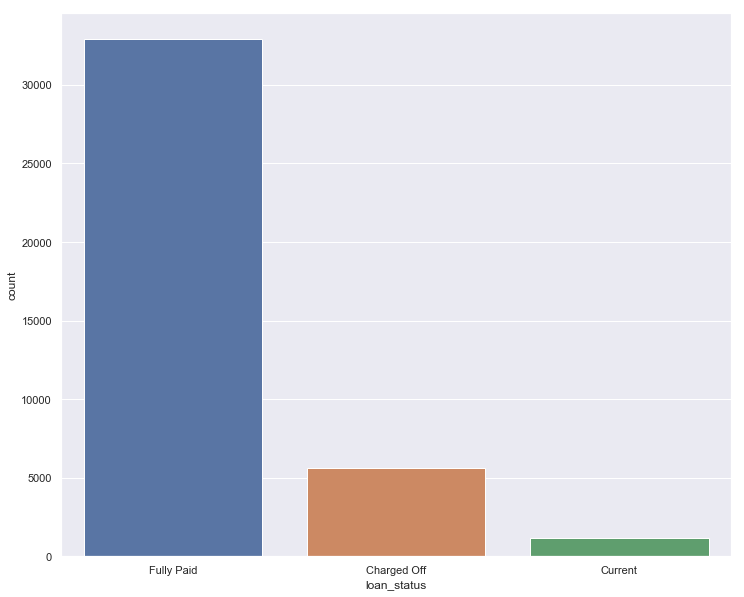

In [5]:
# set figure size
sns.set(rc={'figure.figsize':(12,10)})
# see proportion of loan status our target variable
sns.countplot(loan_all_df.loan_status)

As our goal would be to find differentiating factors between customers who would fully pay vs customer who would default, our observation will come from these two sets of customers in the historic data.  
Therefore we can ignore the data where the loan is currently ongoing. We would not know whether these will be fully paid or defaulted.

In [6]:
# Keep only the rows where loan_status is not Current
loan_df = loan_all_df.loc[loan_all_df.loan_status != 'Current']
loan_df.shape

(38577, 111)

Let's see what is the proportion of charged off customers with respect to Fully paid in the data set 

In [7]:
print(loan_df.groupby("loan_status")['loan_status'].agg(['count'])/len(loan_df))
      

                count
loan_status          
Charged Off  0.145864
Fully Paid   0.854136


That Fully paid is around 85% and Charged off is around 15%

# Data Cleaning and Manipulation

## Data Sanity Checks

Lets first do a round of sanity check to remove columns that does not have any information or does not have any variance

In [8]:
# Find out percentage of missing values in each column
columns = loan_df.columns
percent_missing = loan_df.isnull().sum() * 100 / len(loan_df)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending = False, inplace=True)

# list the columns that have 100% missing values
missing_value_df[missing_value_df.percent_missing == 100]

,column_name,percent_missing
verification_status_joint,verification_status_joint,100.0
annual_inc_joint,annual_inc_joint,100.0
mo_sin_old_rev_tl_op,mo_sin_old_rev_tl_op,100.0
mo_sin_old_il_acct,mo_sin_old_il_acct,100.0
bc_util,bc_util,100.0
bc_open_to_buy,bc_open_to_buy,100.0
avg_cur_bal,avg_cur_bal,100.0
acc_open_past_24mths,acc_open_past_24mths,100.0
inq_last_12m,inq_last_12m,100.0
total_cu_tl,total_cu_tl,100.0


All those above columns can be deleted as they don't have any information and is not going to help us in the analysis anyways. If business think that any of these columns may have impact to find difference between fully paid and charged off then we are not looking at right sample. Business should be advised to provide right sample set of data.

In [9]:
# drop columns that have 100% mising values
loan_df.drop(columns=list(missing_value_df.loc[missing_value_df.percent_missing == 100,'column_name']),inplace = True)
loan_df.shape

C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(38577, 56)

Lets find out numeric columns where there is no variance, i.e. it contains same value in all its rows.

In [10]:
# find out columns that have 0 standard deviation
loan_df.std()[loan_df.std() == 0]

out_prncp                     0.0
out_prncp_inv                 0.0
collections_12_mths_ex_med    0.0
policy_code                   0.0
acc_now_delinq                0.0
chargeoff_within_12_mths      0.0
delinq_amnt                   0.0
tax_liens                     0.0
dtype: float64

These columns are not going to help us either

In [11]:
# dropping column with standard deviation 0
loan_df.drop(loan_df.std()[loan_df.std() == 0.0].index.values, axis=1,inplace = True)
loan_df.shape

(38577, 48)

Lets find out non-numeric columns containing single values only.

In [12]:
# checking whether there are columns having single values. Standard deviation check will not work for non-numeric columns
uniques = loan_df.apply(lambda x: x.nunique())
uniques[uniques==1]

pymnt_plan             1
initial_list_status    1
application_type       1
dtype: int64

The above non-numeric columns contain single values. Thus not helpful either.

In [13]:
# dropping columns having single values
loan_df = loan_df.drop(uniques[uniques==1].index, axis=1)
loan_df.shape

(38577, 45)

After understanding the data data definitions from data dictionary we see that following fields will not be available for new customer while applying for loan. Therefore these features cannot be used for finding features.  
* `last_credit_pull_d` - The most recent month LC pulled credit for this loan
* `last_pymnt_amnt` - Last total payment amount received
* `collection_recovery_fee` - post charge off collection fee
* `delinq_2yrs` - The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
* `mths_since_last_delinq` - The number of months since the borrower's last delinquency.
* `last_pymnt_d` - Last month payment was received
* `recoveries`  - post charge off gross recovery
* `total_pymnt` - Payments received to date for total amount funded
* `total_pymnt_inv`- Payments received to date for portion of total amount funded by investors
* `total_rec_int` - Interest received to date
* `total_rec_late_fee` - Late fees received to date
* `total_rec_prncp` - Principal received to date

In [14]:
# Drop columns that will not be available at the time of aproving loan
columns_to_remove = ['last_credit_pull_d',
                     'last_pymnt_amnt',
                    'collection_recovery_fee',
                     'delinq_2yrs',
                     'mths_since_last_delinq',
                     'last_pymnt_d',
                     'recoveries',
                     'total_pymnt',
                     'total_pymnt_inv',
                     'total_rec_int',
                     'total_rec_late_fee',
                     'total_rec_prncp'
                    ]
loan_df.drop(columns_to_remove , axis = 1 , inplace = True)
loan_df.shape

(38577, 33)

Lets now find out the columns that have very high unique values

In [15]:
# Check potential unique value fields 
df_colunique = pd.DataFrame(loan_df.nunique()/loan_df.count())
# Columns having all unique values excludeing Nulls
df_colunique.loc[df_colunique[0] >= 0.99]

,0
id,1.000000
member_id,1.000000
url,1.000000
desc,0.990518


As we can see these are mostly id columns or free text columns. Therefore we'll not be able to get any pattern form these columns

In [16]:
# drop the columns where each row has unique values
loan_df.drop(df_colunique.loc[df_colunique[0] >= 0.99].index, axis=1, inplace= True)
loan_df.shape

(38577, 29)

### Missing Value treatments

Lets see the missing values in the data

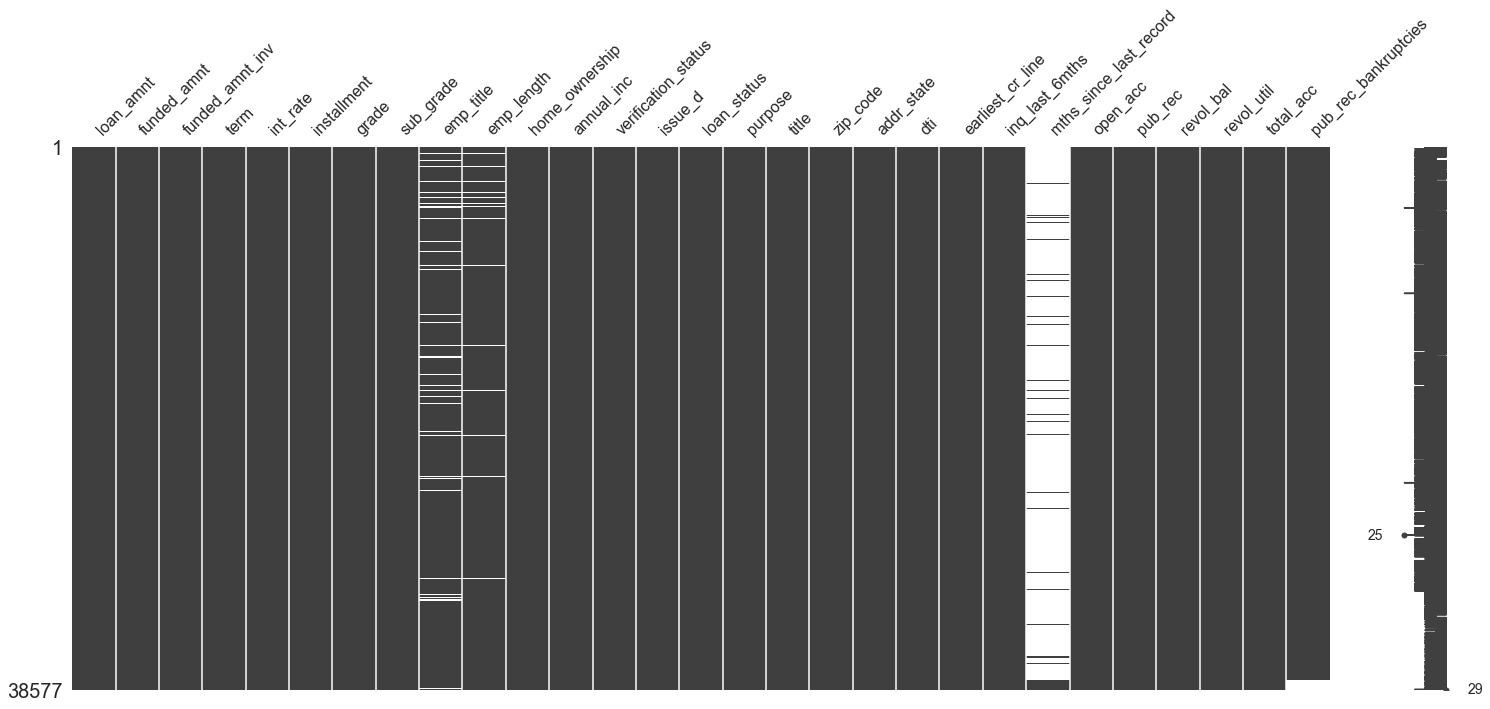

In [17]:
# visualize missing data
msno.matrix(loan_df)

The above and below graph shows that there missing values the following 4 columns:
* `emp_length`
* `emp_title`
* `title`
* `revol_util`
* `mths_since_last_record`
* `pub_rec_bankruptcies`  
Amongst these only `mths_since_last_record` has huge number of missing records

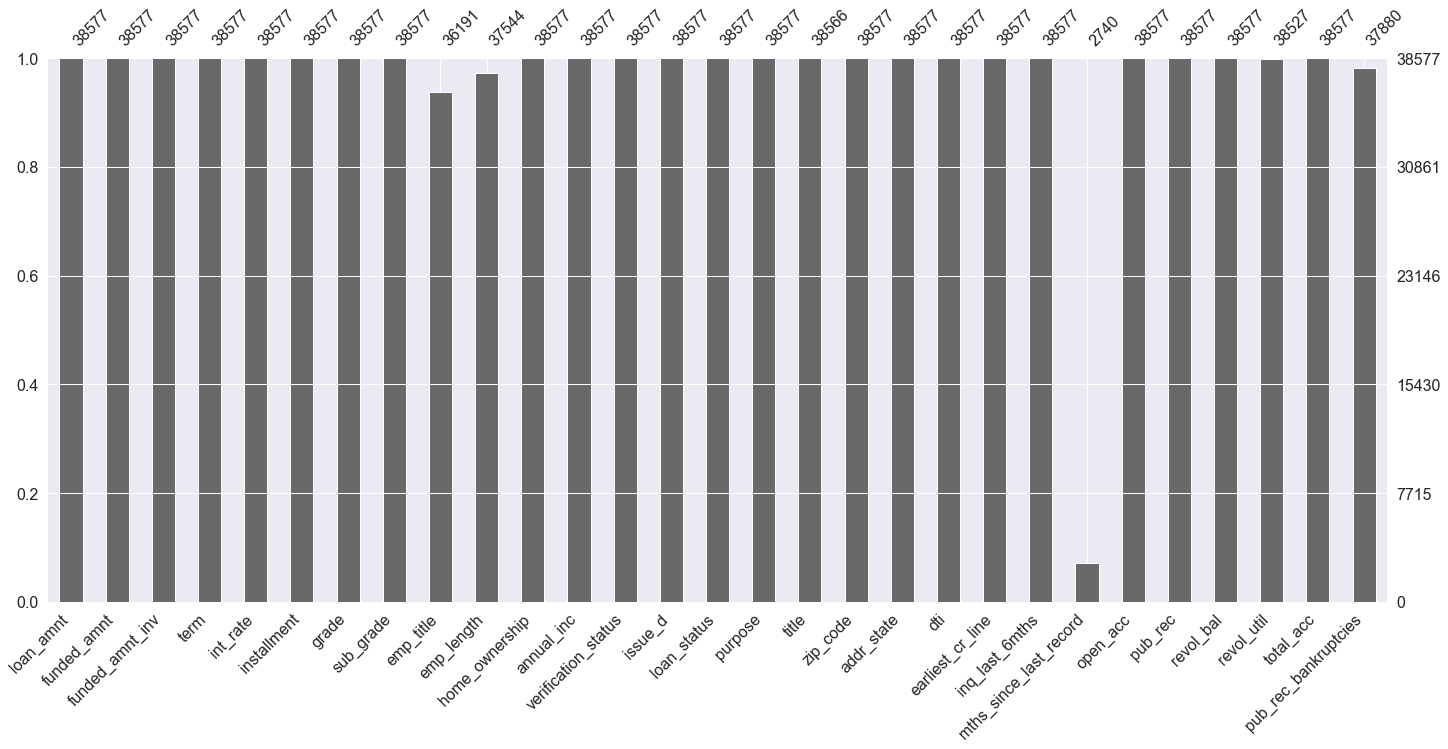

In [18]:
msno.bar(loan_df)

The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.  
The below heat map shows that `emp_length` and `emp_title` are missing together in 60% cases and `mths_since_last_record` and `pub_rec_bankruptcies` are missing together 50% times.

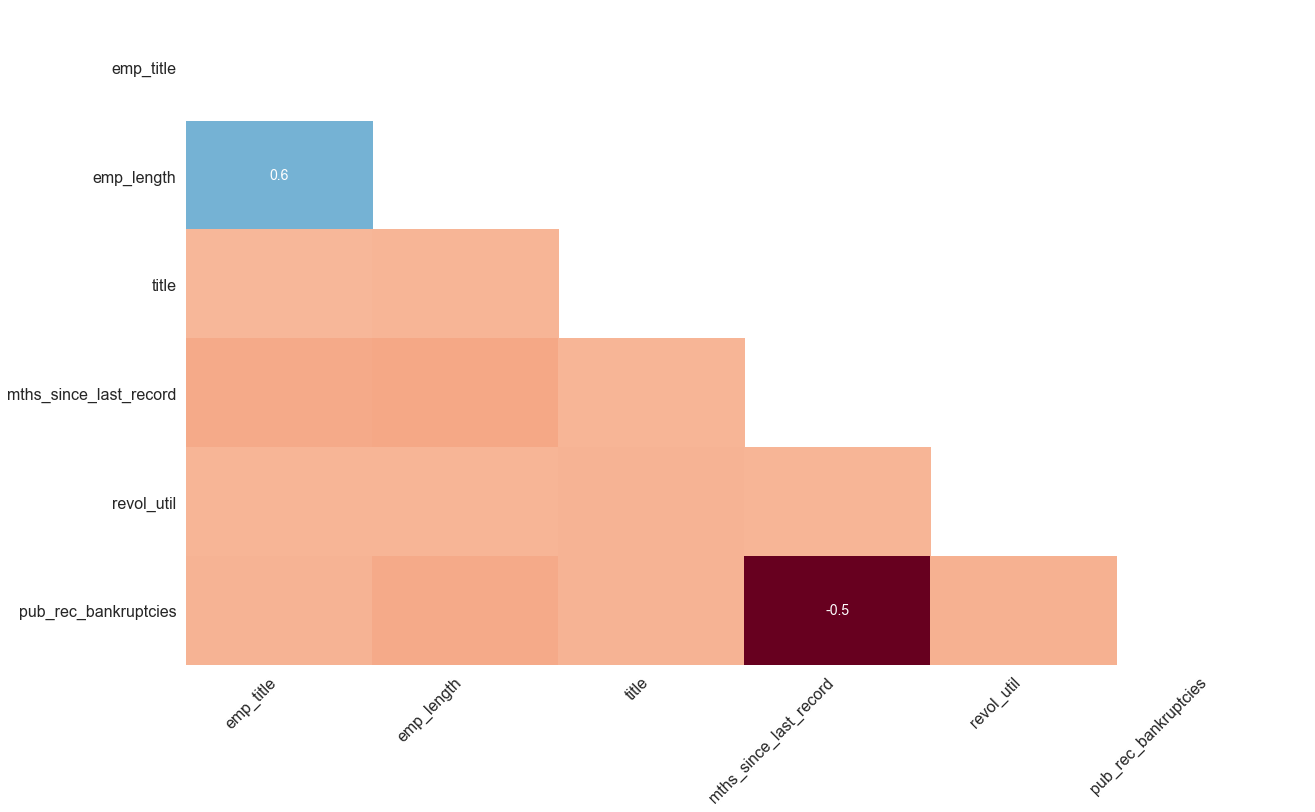

In [19]:
msno.heatmap(loan_df)

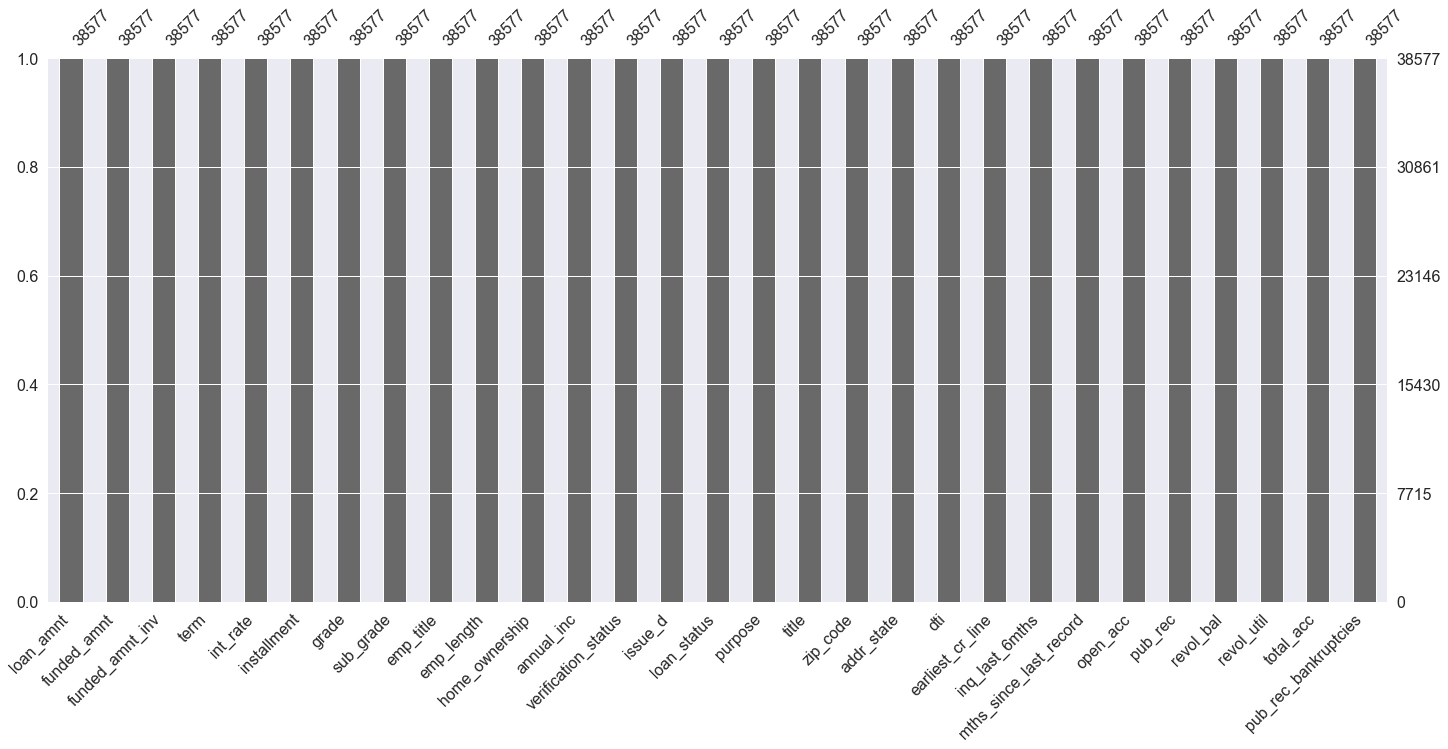

In [20]:
# Impute missing values
values = {'emp_length': 'NA', 'emp_title': 'NA', 'title': 'NA',\
          'revol_util': '0%', 'mths_since_last_record': -1, 'pub_rec_bankruptcies':0}
loan_df.fillna(value=values, inplace = True)
msno.bar(loan_df)

### Data Manipulations

In general we'll first delete and leading and training spaces

In [21]:
# Strip all columns for leading and lagging spaces
loan_df = loan_df.applymap(lambda s : s.strip() if type(s) is str else s)

We observe that the term field has month as suffix, so we trim that and convert to number

In [22]:
# Remove string months from term 
loan_df.term = loan_df.term.apply(lambda s : s[0:s.index(' ')] if ' ' in s else s)
loan_df.term = pd.to_numeric(loan_df.term)
loan_df.term.head()

0    36
1    60
2    36
3    36
5    36
Name: term, dtype: int64

We observe that int_rate and revol_util field has % as suffix, we remove that and convert to number

In [23]:
# Remove % sign from interest rate 
loan_df.int_rate = loan_df.int_rate.apply(lambda s : s[0:s.index('%')] if '%' in s else s)
loan_df.int_rate = pd.to_numeric(loan_df.int_rate)
loan_df.int_rate.head()

0    10.65
1    15.27
2    15.96
3    13.49
5     7.90
Name: int_rate, dtype: float64

In [24]:
# Remove % sign from revol_util
loan_df.revol_util = loan_df.revol_util.apply(lambda s : s[0:s.index('%')] if '%' in s else s)
loan_df.revol_util = pd.to_numeric(loan_df.revol_util)
loan_df.revol_util.head()

0    83.7
1     9.4
2    98.5
3    21.0
5    28.3
Name: revol_util, dtype: float64

In [25]:
loan_df_cat = loan_df.select_dtypes(['object'])
# Check potential unique value fields 
loan_df_cat_colunique = pd.DataFrame(loan_df_cat.nunique()/loan_df_cat.count())
# Columns having all unique values excludeing Nulls
loan_df_cat_colunique

,0
grade,0.000181
sub_grade,0.000907
emp_title,0.721414
emp_length,0.000311
home_ownership,0.000130
verification_status,0.000078
issue_d,0.001426
loan_status,0.000052
purpose,0.000363
title,0.493247


We found that following columns either have very high variance or does not add much information
* `title`: very high variance
* `emp_title`: very high variance
* `zip_code`: Not so high variance but lots of values. Addr_state can cover for this variable.

In [26]:
# Drop columns that will can not have any impact
columns_to_remove = ['title' , # very high variance
                     'emp_title', # very high variance
                     'zip_code' # Not so high variance but lots of values where addr_state can cover
                    ]
loan_df.drop(columns_to_remove , axis = 1 , inplace = True)
loan_df.shape

(38577, 26)

Lets see if we have any duplicate rows.

In [27]:
# checking whether there are duplicate rows
loan_df.duplicated().sum()

0

In [28]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 26 columns):
loan_amnt                 38577 non-null int64
funded_amnt               38577 non-null int64
funded_amnt_inv           38577 non-null float64
term                      38577 non-null int64
int_rate                  38577 non-null float64
installment               38577 non-null float64
grade                     38577 non-null object
sub_grade                 38577 non-null object
emp_length                38577 non-null object
home_ownership            38577 non-null object
annual_inc                38577 non-null float64
verification_status       38577 non-null object
issue_d                   38577 non-null object
loan_status               38577 non-null object
purpose                   38577 non-null object
addr_state                38577 non-null object
dti                       38577 non-null float64
earliest_cr_line          38577 non-null object
inq_last_6mths           

We'll progress our analysis on the above 26 variables and 38577 rows

# Data analysis

## Custom Functions

### Univariate and segmented univariate analysis on categorical variables

The following function is created to do univariate and segmented univariate analysis of categorical variables. This function will accept a data frame having subject column and loan_status column will provide following graphs.
* rank frequency plot
* bar plot
* grouped bar plot
* Mosaic plot

In [29]:
# Perform Univariate Analysis

# Write Function to perform univariate analysis on categorical variables 

def uni_analysis_cat (x , summary = 0, pct_label = True):
    print(x.iloc[:,0].describe())
    # preparing data for label in mosaic plot
    count_table = x.groupby(list(x.columns)).size()#.reset_index(name='counts')
    pct_table = count_table.groupby(level=0).apply(lambda x:
                                                 round(x / float(x.sum()),2))\
                                    .unstack(fill_value=0)
                                
    pct_table.index = pct_table.index.map(str)
    pct_table = pct_table.stack()
   
    sns.set(rc={'figure.figsize':(15,6)})
    # rank frequency plot
    ax = x.iloc[:,0].value_counts().plot(kind='barh')
    ax.set(xlabel="count", ylabel=list(x.columns)[0])
    plt.show()
    f, axes = plt.subplots(1, 2)
       
    if(~summary):
        print('****************************************************************************************************')
        # bar plot
        sns.countplot( x = x.iloc[:,0], data = x , ax = axes[0])
        
        # Grouped bar plot
        sns.countplot( x = x.iloc[:,0], hue = x.iloc[:,1] , data = x , ax = axes[1] )
        
        # change label direction
        for ax in f.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        # create proportion labelizer for mosaic plot
        if pct_label:
            labelizer = lambda k: pct_table.loc[pd.IndexSlice[k[0]],pd.IndexSlice[k[1]],:].values[0]
        else:
            labelizer = lambda k: ''
        
        # mosaic plot
        mosaic(x.sort_values(list(x.columns)[0]),
               list(x.columns),
               label_rotation = [90,0], 
               labelizer=labelizer)

### Univariate and segmented univariate analysis for quantitative variable 

The following function is created to do univariate and segmented univariate analysis of numeric variables. This function will accept a data frame having subject column and loan_status column will provide following graphs.
* box plot
* segmented box plot
* segmented distribution plot

In [30]:
# Univariate analysis for quantitative variable 


def uni_analysis_num (x , type = 'r', log_scale=False):
    sns.set(rc={'figure.figsize':(15,6)})
    f, axes = plt.subplots(1, 3)
    
    # print column description
    print(round(x.iloc[:,0].describe(),2))

    print('****************************************************************************************************')
    # for each unique value in 2nd column
    for value in list(x.iloc[:,1].unique()):
        a = x.loc[x.iloc[:,1] == value,list(x.columns)[0]]
        a.rename(index = value, inplace = True)
        # kde plot for 1 distribution
        p1=sns.kdeplot(a, shade=True)
    if log_scale: p1.set_xscale('log')
    p1.set_xlabel(list(x.columns)[0])
    p1.set_ylabel('Probability')
    
    # mean indicator marker
    meanpointprops = dict(marker='D', markeredgecolor='black',
              markerfacecolor='firebrick')
    # box plot
    bp = sns.boxplot( y = x.iloc[:,0], data = x , ax = axes[0],color = 'g',
                     showmeans=True, meanprops=meanpointprops, meanline=False)
    if log_scale: bp.set_yscale('log')

    # segmented box plot
    vp = sns.boxplot( x = x.iloc[:,1] , y = x.iloc[:,0] , data = x , ax = axes[1],\
                     showmeans=True, meanprops=meanpointprops, meanline=False)
    #vp = sns.violinplot( x = x.iloc[:,1] , y = x.iloc[:,0] , data = x , ax = axes[1], \
    #               vert = True , inner = 'quartile' ,scale_hue = True )
    if log_scale: vp.set_yscale('log')


### Bubble Plot to visualise date dependency

In [31]:
def bubble_plot(x , y , z ,percent):
    plt.rcParams.update({'font.size': 12})

    plt.figure(figsize=(10, 6))
    
    plt.scatter(x = x
                , y = y , 
                s = percent * 100,
                c = 'r',
               alpha = 0.8)

    
    for i in range(0,len(x)):
        plt.text(x[i] ,y[i], s= percent[i].round(2) , ha = 'left', va = 'center', fontsize = 12)

    plt.show()

### Bivariate Analysis for Quantitative variables

In [32]:
# Bivariate analysis : Common function to perform correlation within data frame 

def bi_analysis_num(df):
    sns.set(rc={'figure.figsize':(15,6)})
    f, axes = plt.subplots(1, 2)
    
    #sns.heatmap(df.corr(), fmt='0.2f', annot=True , cmap = 'Greens')
    dfc = df.loc[df.loan_status == 'Charged Off']
    dff = df.loc[df.loan_status == 'Fully Paid']
    
    print('The correlation matrix is as below')
    print(df.corr())
    print('**********************************************************************************')
    
    sns.kdeplot(dfc.iloc[:,0] , dfc.iloc[:,1] ,  cmap="Reds", shade=True, shade_lowest=False , ax = axes[0])
    sns.kdeplot(dff.iloc[:,0] , dff.iloc[:,1] ,  cmap="Blues", shade=True, shade_lowest=False , ax = axes[1])

### Bivariate analysis for Categorical variable

In [33]:
# Bivariate analysis for categorical variables : Common function to perform correlation within data frame 

def bi_analysis_cat(df):
    sns.set(rc={'figure.figsize':(15,6)})
   
    
    ct = pd.crosstab(df.iloc[:,1] , df.iloc[:,2] , margins = True , \
                     margins_name = 'Total' , normalize = True).round(4) * 100
    
    print('The summary table is as below')
    print(ct)
    print('**********************************************************************************')
       
    sns.violinplot( x = df.iloc[:,1] , y = df.iloc[:,0] ,  hue = df.iloc[:,2] , data = df , \
                   vert = True , inner = 'quartile' ,scale_hue = True , split = True , annot = True )

### Independent t test

The following function is created to perform t test between two numeric distributions. This function will accept two different distributions separately and provide p-value of the test.

In [34]:
# Function to perform t-test for 2 independent data sets 
# Not usable yet

def independant_ttest(x , y ):
    stat , p = ss.ttest_ind(x, y , equal_var = False)
    #print('t-test stats value =', round(stat, 2))
    print('p value = ' , p)
    
    if ( p < 0.05):
        print('The 2 sets of data differ significantly')
    else:
        print('We cannot state that the 2 sets of data differ significantly')

### Chi-squared test

The following function is created to perform chi-squared test between two categorical fields. This function will accept data frame having subject column and loan_status column and provide p-value of for independence test.

In [35]:

# Create a function for a 2 set test using Pearsons's chi2 method
# https://stattrek.com/chi-square-test/independence.aspx

def chi2_cat_pearson(df):
    ctab = pd.crosstab(df.iloc[:,0] , df.iloc[:,1])
    stat , p , dof , expected = ss.chi2_contingency(ctab)
    
    #print('chi2 stats value is =', round(stat,2))
    print('p value =', p)
    
    if ( p < 0.05):
        print('The 2 data sets are not independent of each other ')
    else:
        print('The 2 data sets are independent of each other')

### Tukey's HSD

The Tukey's honestly significant difference test (Tukey's HSD) is used to test differences among sample means for significance. The Tukey's HSD tests all pairwise differences while controlling the probability of making one or more Type I errors.  
This function will accept data frame having subject column and loan_status column and provide test results.

In [36]:
# Create a function for Tukey's HSD check

def tukeys_hsd(df, p_value=0.05):
    #dta = pd.melt(df, id_vars=list(df.columns)[1], value_vars=list(df.columns)[0])
    #print(dta.head())
    print("Using the pairwise_tukeyhsd Method")
    print("----------------------------------------------------------")
    res2 = pairwise_tukeyhsd(groups= df.iloc[:,1], endog = df.iloc[:,0],  alpha=p_value)
    print("summary:", res2.summary())
    print("mean diffs:", res2.meandiffs)
    print("std pairs:",res2.std_pairs)
    print("groups unique: ", res2.groupsunique)
    print("df total:", res2.df_total)
    p_values = psturng(np.abs(res2.meandiffs / res2.std_pairs), len(res2.groupsunique), res2.df_total)
    print("p values:", p_values)

### Chi-squared post-hoc test

Chi2 Post-hoc test is done post chi2 test to investigate pairwise tests further. This will help in finding out the values in subject categorical variable that are most impacting. This performs Bonferroni adjustment on the p-value based on number of multiple pair test which helps in reducing Type-1 errors.  
This function will accept data frame having subject column and loan_status column and provide values from subject variable which have significant impact on loan status

In [37]:
def chi2_post_hoc(df, p_value = 0.05):
    # prepare data for multiple pairwise tests
    if df.iloc[:,0].dtypes != 'object':
        dummies = pd.get_dummies(df.iloc[:,0],prefix = 'value')
    else:
        dummies = pd.get_dummies(df.iloc[:,0])
    
    #dummies.drop(list(dummies.columns)[0],axis= 1, inplace= True)
    
    adjusted_p = p_value/dummies.shape[1]
    print("Bonferroni-adjusted p-value: ",adjusted_p)
    for series in dummies:
        nl = "\n"
        
        crosstab = pd.crosstab(dummies[f"{series}"], df.iloc[:,1])
        #print(crosstab, nl)
        chi2, p, dof, expected = ss.chi2_contingency(crosstab)
        if p < adjusted_p:
            print("Pairwise comparisons is significant for:",dummies[f"{series}"].name)
            print(f"p-value= {p}{nl}")   

## Analysis of consumer attributes

### `addr_state`: The state provided by the borrower in the loan application

count     38577
unique       50
top          CA
freq       6949
Name: addr_state, dtype: object


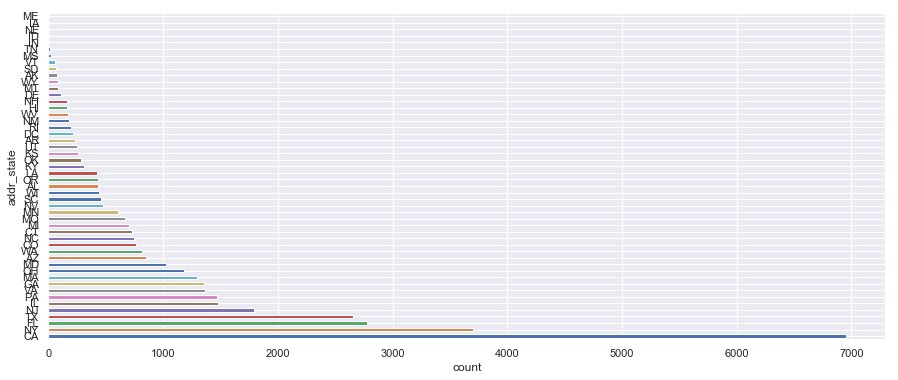

****************************************************************************************************


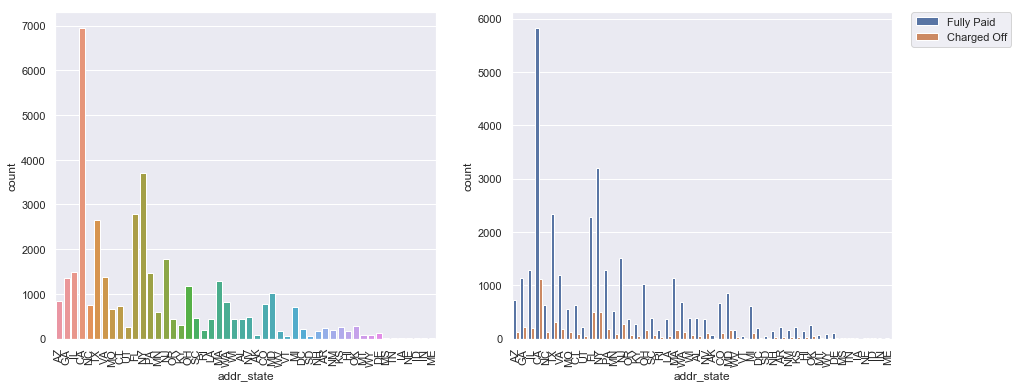

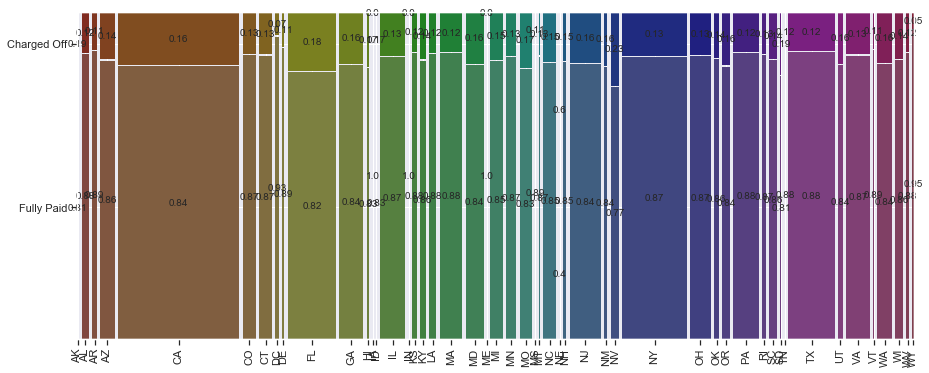

In [38]:
uni_analysis_cat(loan_df[['addr_state' , 'loan_status']] )

The mosaic plot shows a lot of variance in fully paid and charged off numbers in different states. NV has the highest proportion (23%) of charged off customers.  
Let's check for the significance in chi2 test

In [39]:
# chi2 test for addr_state
chi2_cat_pearson(loan_df[['addr_state','loan_status']])

p value = 1.3091680972557555e-13
The 2 data sets are not independent of each other 


Chi2 test says the variable is significant. 

In [40]:
# chi2 post-hoc test for addr_state
chi2_post_hoc(loan_df[['addr_state','loan_status']]) 

Bonferroni-adjusted p-value:  0.001
Pairwise comparisons is significant for: CA
p-value= 3.151968970727524e-05

Pairwise comparisons is significant for: FL
p-value= 4.8342332959601234e-08

Pairwise comparisons is significant for: NV
p-value= 9.49687285722817e-07

Pairwise comparisons is significant for: TX
p-value= 4.849507615880662e-05



Post hoc test confirms the claim. However we this this variable cannot be controlled by Lending Club. Therefore will NOT be considered as one of the most significant drivers.

### `annual_inc`: The self-reported annual income provided by the borrower during registration

count      38577.00
mean       68777.97
std        64218.68
min         4000.00
25%        40000.00
50%        58868.00
75%        82000.00
max      6000000.00
Name: annual_inc, dtype: float64
****************************************************************************************************


C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


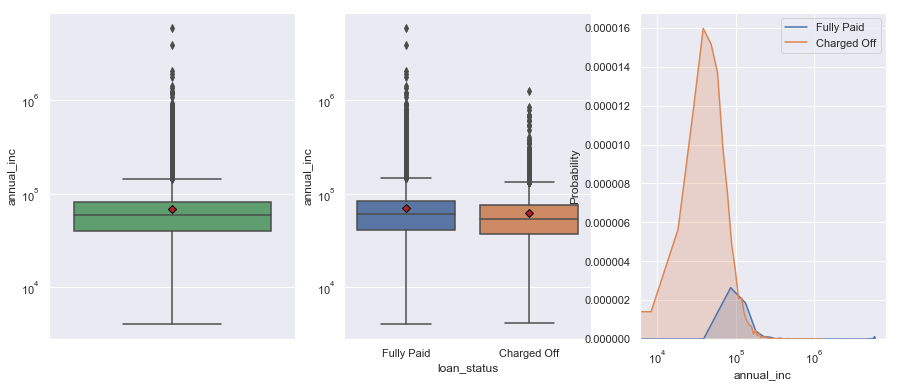

In [41]:
uni_analysis_num(loan_df[['annual_inc', 'loan_status']], log_scale=True)

The segmented box plot clearly shows there is variation in median and mean of annual income between Fully paid and charged off segments even in log scale. I.e. in actual scale, the differences will be very significant.  
Lets test for statistical significance in difference using t-test.

In [42]:
# Independent T test for annual_income
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].annual_inc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].annual_inc)

p value =  6.085598735005217e-24
The 2 sets of data differ significantly


t-test indicates that the annual income distributions are significantly different for fully paid and charged off segments for significant level 0.05.  
We'll now confirm the same using post-hoc test Tukey's HSD with alpha level 0.05 below

In [43]:
# Tukey's HSD for annual_income
tukeys_hsd(loan_df[['annual_inc','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:      Multiple Comparison of Means - Tukey HSD,FWER=0.05    
   group1     group2    meandiff   lower     upper   reject
-----------------------------------------------------------
Charged Off Fully Paid 7435.2053 5621.0944 9249.3162  True 
-----------------------------------------------------------
mean diffs: [7435.2052936]
std pairs: [654.46603012]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The above test confirms that we can reject the null hypothesis and from the mean difference we can conclude lower the annual income higher the chances for customer to default 

__`annual_income` is one of the most important variables that Lending club should be interested in to make the decision__

### `verification_status`: Indicates if income was verified by LC, not verified, or if the income source was verified

count            38577
unique               3
top       Not Verified
freq             16694
Name: verification_status, dtype: object


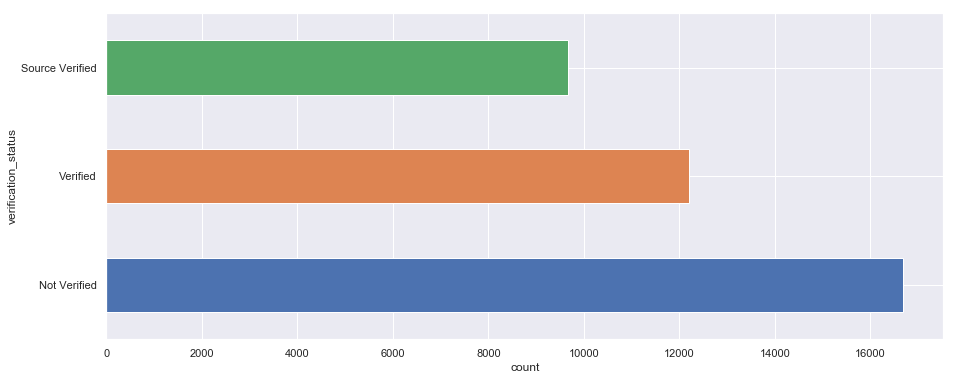

****************************************************************************************************


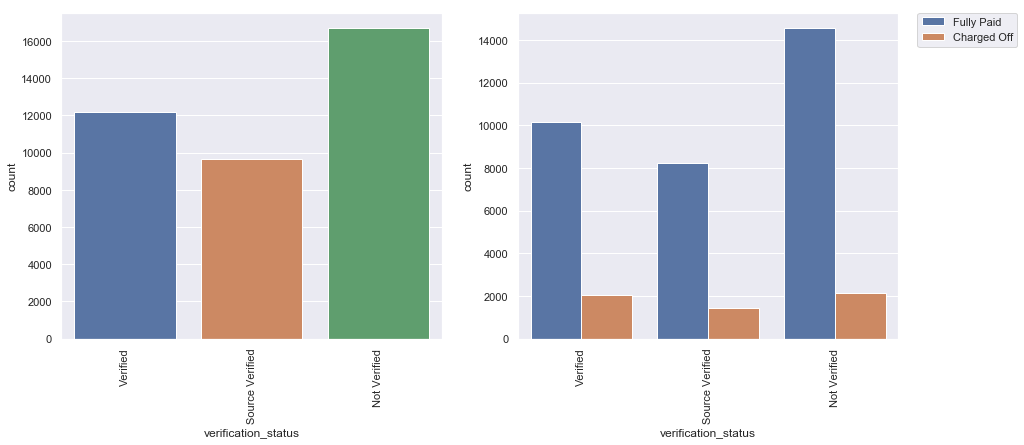

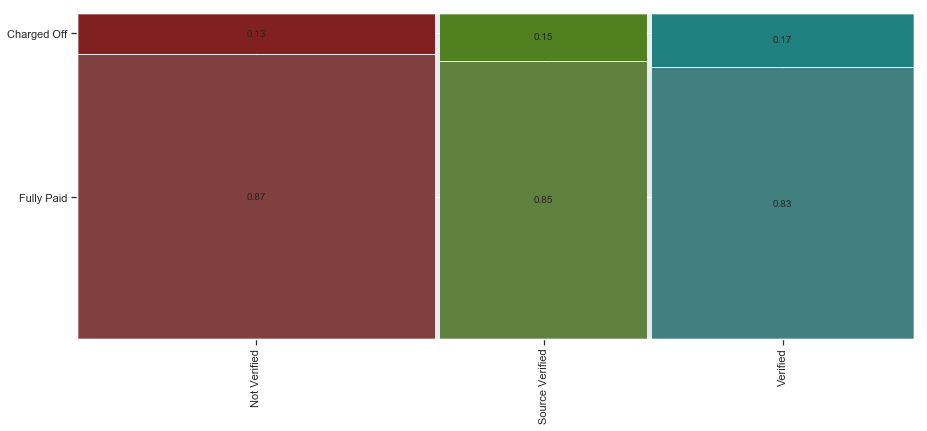

In [44]:
uni_analysis_cat(loan_df[['verification_status', 'loan_status']])

The Mosaic plot shows some variation in fully paid and charged off numbers in different levels of verification status.  
Lets test this with chi2 test

In [45]:
# chi2 test for home_ownership
chi2_cat_pearson(loan_df[['verification_status','loan_status']])

p value = 3.0766987809614244e-20
The 2 data sets are not independent of each other 


chi2 test shows that verification status has impact on loan_status.

In [46]:
# chi2 post-hoc test for verification_status
chi2_post_hoc(loan_df[['verification_status','loan_status']])

Bonferroni-adjusted p-value:  0.016666666666666666
Pairwise comparisons is significant for: Not Verified
p-value= 1.6333613543746047e-17

Pairwise comparisons is significant for: Verified
p-value= 5.4430819602681094e-17



post-hoc test confirms the claim from chi2 test. However does not make right intuition as verified income has more charged off scenarios.

This highlights possible process gap, may be Lending Club should re-look at there income verification process

### `dti`: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

count    38577.00
mean        13.27
std          6.67
min          0.00
25%          8.13
50%         13.37
75%         18.56
max         29.99
Name: dti, dtype: float64
****************************************************************************************************


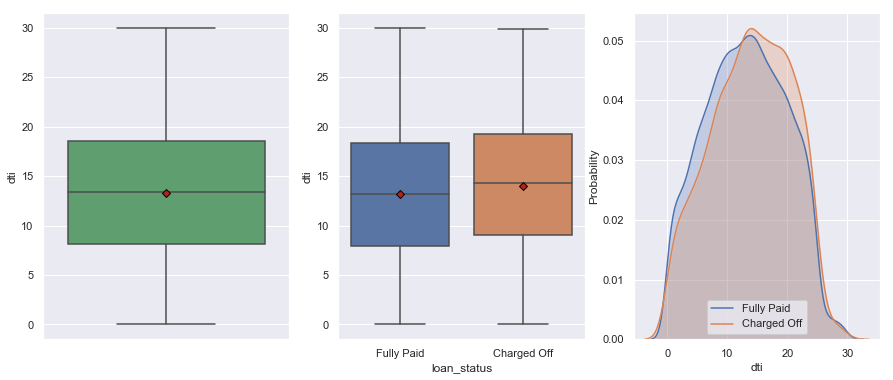

In [47]:
uni_analysis_num(loan_df[['dti', 'loan_status']])

Box plot indicates median difference of dti for fully paid and charged off. Mean is also different for these segments but less than median differene.

In [48]:
# Independent T test for dti
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].dti ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].dti)

p value =  4.2981134180459247e-19
The 2 sets of data differ significantly


t-test shows that these 2 distributions are not same.

In [49]:
# Tukey's HSD for dti
tukeys_hsd(loan_df[['dti','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1     group2   meandiff  lower   upper  reject
------------------------------------------------------
Charged Off Fully Paid -0.8522  -1.0407 -0.6637  True 
------------------------------------------------------
mean diffs: [-0.85220253]
std pairs: [0.06799406]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


Tukey's HSD confirms the claim. However as we are considering annual income as one of significant variable 

### `emp_length`: Employment length in years

count         38577
unique           12
top       10+ years
freq           8488
Name: emp_length, dtype: object


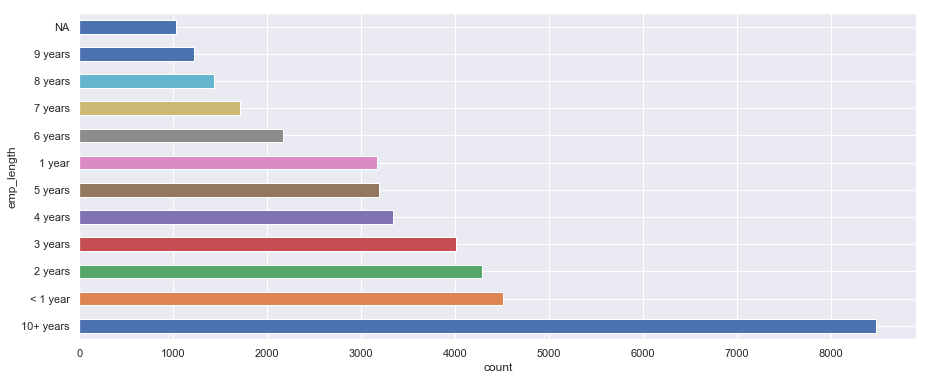

****************************************************************************************************


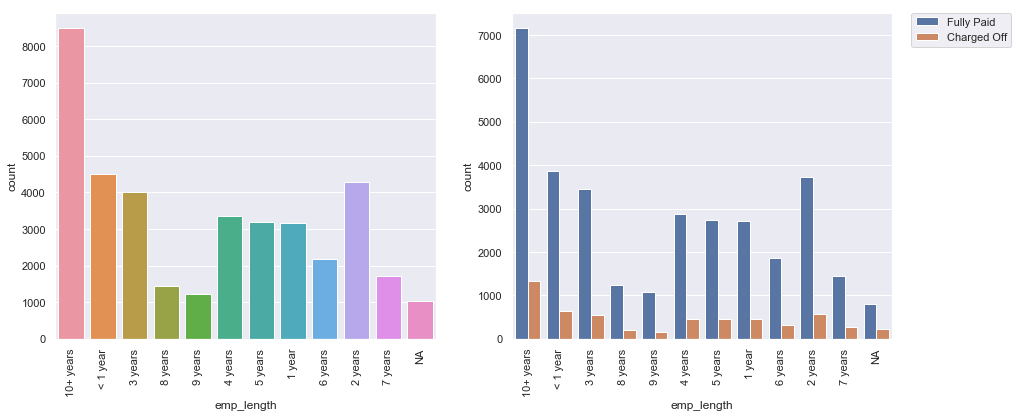

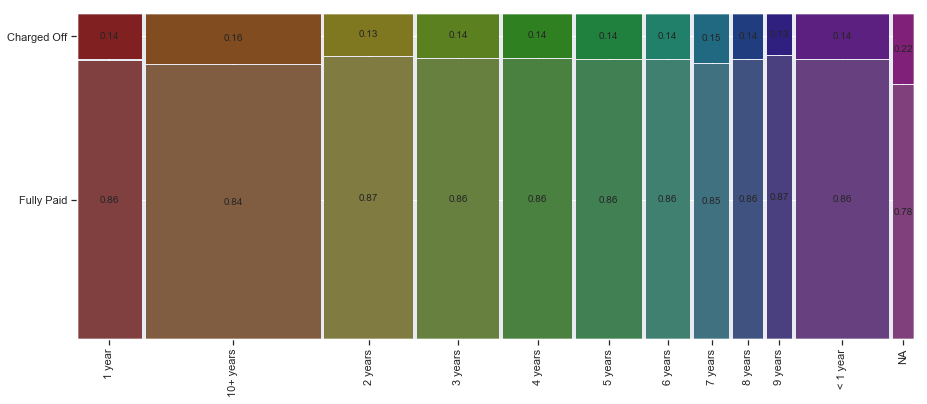

In [50]:
uni_analysis_cat(loan_df[['emp_length', 'loan_status']])

Mosaic plot does not show a lot of variance between fully paid and charged off of different employment years except where the employment length is not provided. 

In [51]:
# chi2 test for emp_length
chi2_cat_pearson(loan_df[['emp_length','loan_status']])

p value = 1.4650844632276886e-10
The 2 data sets are not independent of each other 


Chi2 test showing that these two variable are not independent

In [52]:
# chi2 post-hoc test for emp_length
chi2_post_hoc(loan_df[['emp_length','loan_status']]) 

Bonferroni-adjusted p-value:  0.004166666666666667
Pairwise comparisons is significant for: 10+ years
p-value= 0.0012931747668068407

Pairwise comparisons is significant for: NA
p-value= 6.683647510311461e-12



post-hoc test confirms the claim. However we don't find this to be very significant specially where employee length is provided. This might mean another process issues. Lending Club should investigate why employee length is not provided. If this is because customer is not employed, then in what grounds loan is getting approved

### `home_ownership`: The home ownership status provided by the borrower during registration

count     38577
unique        5
top        RENT
freq      18480
Name: home_ownership, dtype: object


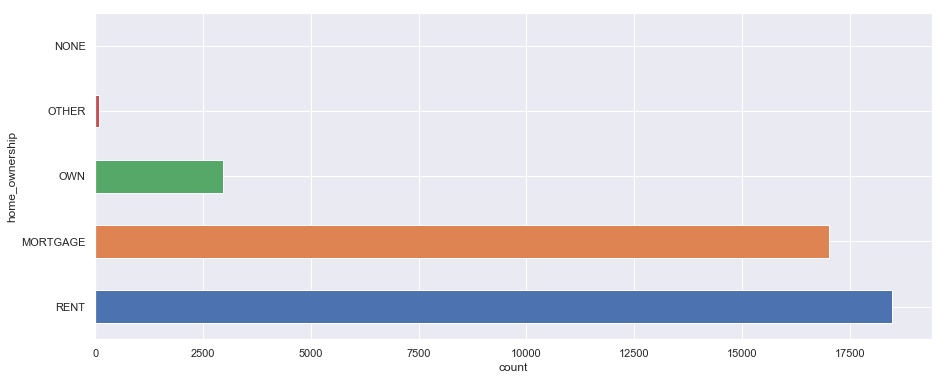

****************************************************************************************************


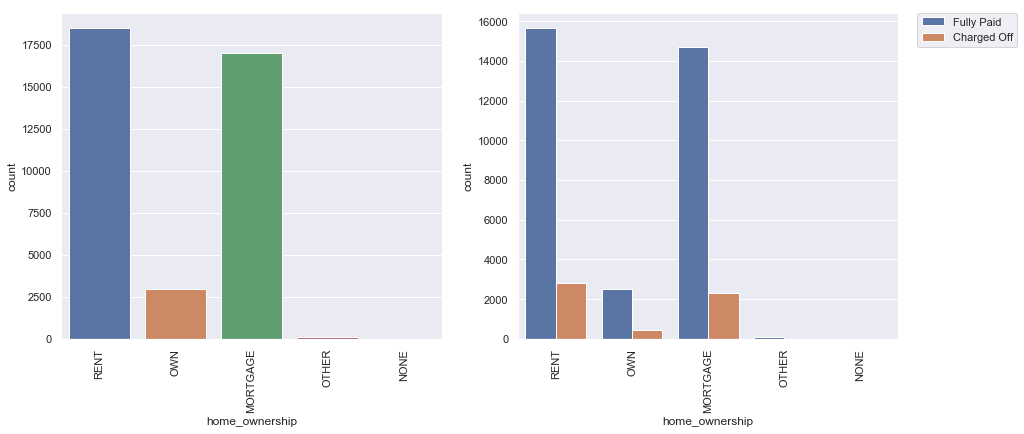

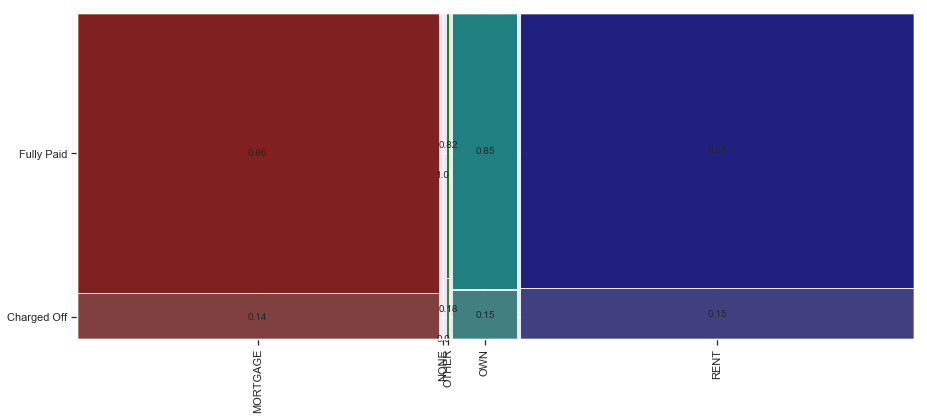

In [53]:
# Univariate analysis of Home ownership and comparison with home status

uni_analysis_cat(loan_df[['home_ownership' , 'loan_status']])

In [54]:
# chi2 test for home_ownership

chi2_cat_pearson(loan_df[['home_ownership','loan_status']])

p value = 0.00018011714098862449
The 2 data sets are not independent of each other 


In [55]:
# chi2 post-hoc test for home_ownership
chi2_post_hoc(loan_df[['home_ownership','loan_status']]) 

Bonferroni-adjusted p-value:  0.01
Pairwise comparisons is significant for: MORTGAGE
p-value= 6.4784248165076894e-06

Pairwise comparisons is significant for: RENT
p-value= 3.674916052680976e-05



Mosaic plot does not show a lot of variance between fully paid and charged off for different home ownership  statuses even if chi2 and post-hoc states otherwise. We are NOT considering this to be a significant variable.

### `mths_since_last_record`: The number of months since the last public record

count    38577.00
mean         3.99
std         21.52
min         -1.00
25%         -1.00
50%         -1.00
75%         -1.00
max        129.00
Name: mths_since_last_record, dtype: float64
****************************************************************************************************


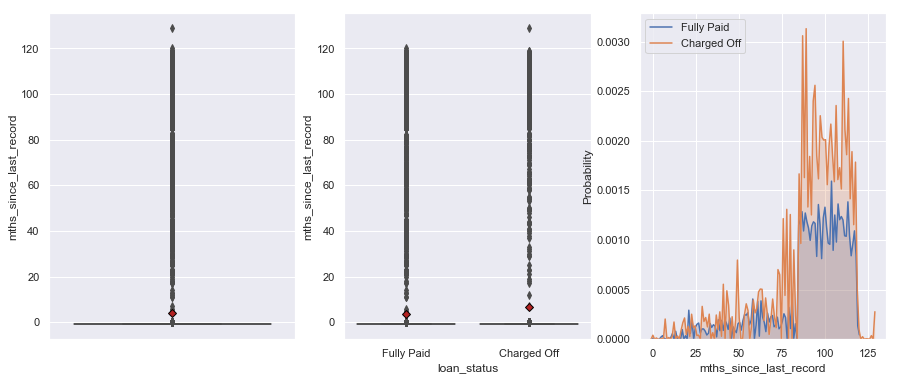

In [56]:
uni_analysis_num(loan_df[['mths_since_last_record', 'loan_status']])

In [57]:
# Independent T test for mths_since_last_record
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].mths_since_last_record ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].mths_since_last_record)

p value =  1.9685986735837562e-18
The 2 sets of data differ significantly


In [58]:
# Tukey's HSD for mths_since_last_record
tukeys_hsd(loan_df[['mths_since_last_record','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1     group2   meandiff  lower   upper  reject
------------------------------------------------------
Charged Off Fully Paid -3.2587  -3.8662 -2.6511  True 
------------------------------------------------------
mean diffs: [-3.25868587]
std pairs: [0.21918669]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The spread for fully paid and charged off loans seams to be same, so distinction cannot be made
further, the values are concentrated between 0 and 20.  
Even if T test and Tukey's HSD states otherwise, we are NOT considering this to be a significant variable.


### `open_acc`: The number of open credit lines in the borrower's credit file

count    38577.00
mean         9.28
std          4.40
min          2.00
25%          6.00
50%          9.00
75%         12.00
max         44.00
Name: open_acc, dtype: float64
****************************************************************************************************


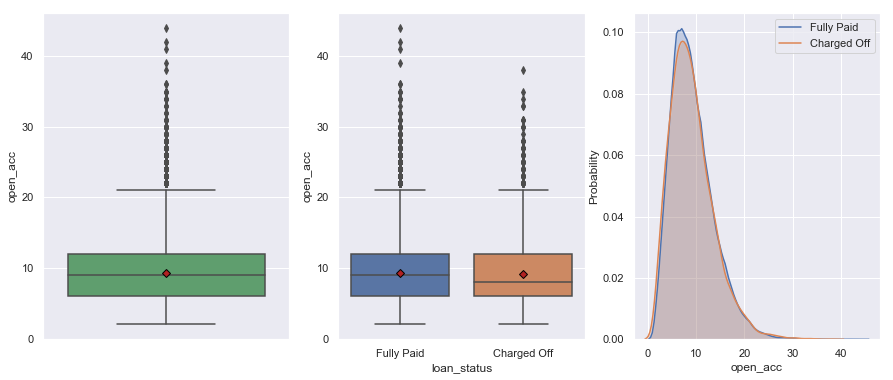

In [59]:
uni_analysis_num(loan_df[['open_acc', 'loan_status']])

In [60]:
# Independent T test for open_acc
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].open_acc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].open_acc)

p value =  0.07946561585420775
We cannot state that the 2 sets of data differ significantly


In [61]:
# Tukey's HSD for open_acc
tukeys_hsd(loan_df[['open_acc','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:   Multiple Comparison of Means - Tukey HSD,FWER=0.05 
   group1     group2   meandiff  lower  upper  reject
-----------------------------------------------------
Charged Off Fully Paid  0.114   -0.0105 0.2384 False 
-----------------------------------------------------
mean diffs: [0.11397854]
std pairs: [0.04489314]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: [0.072618]


The spread for fully paid and charged off loans seams to be same, so distinction cannot be made.  
This is confirmed by both t test and Tukey's HSD test

### `total_acc`: The total number of credit lines currently in the borrower's credit file

count    38577.00
mean        22.05
std         11.43
min          2.00
25%         13.00
50%         20.00
75%         29.00
max         90.00
Name: total_acc, dtype: float64
****************************************************************************************************


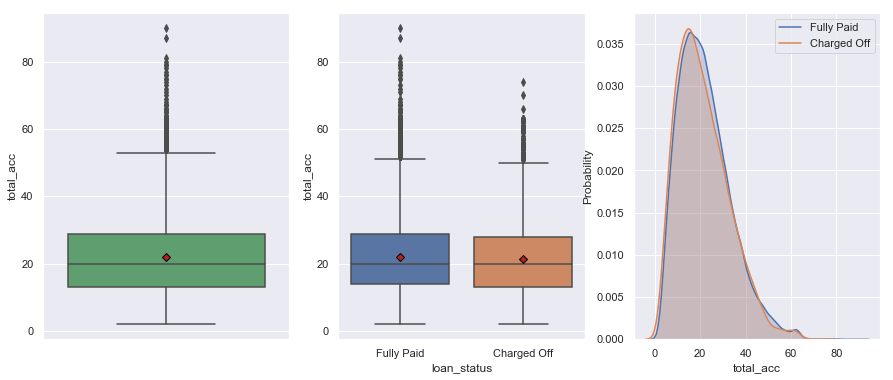

In [62]:
uni_analysis_num(loan_df[['total_acc', 'loan_status']])

In [63]:
# Independent T test for total_acc
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].total_acc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].total_acc)

p value =  9.398879853298546e-06
The 2 sets of data differ significantly


In [64]:
# Tukey's HSD for total_acc
tukeys_hsd(loan_df[['total_acc','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
   group1     group2   meandiff lower  upper  reject
----------------------------------------------------
Charged Off Fully Paid  0.7318  0.4089 1.0548  True 
----------------------------------------------------
mean diffs: [0.73181172]
std pairs: [0.11651091]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The spread for fully paid and charged off loans seams to be same, so distinction cannot be made
further, the values are concentrated between 0 and 20.  
Even if T test and Tukey's HSD states otherwise, we are NOT considering this to be a significant variable.

### `pub_rec`: Number of derogatory public records

Even if the values are Numeric, we are considering this to be categorical as only 4 values are available

count    38577.000000
mean         0.055422
std          0.237804
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: pub_rec, dtype: float64


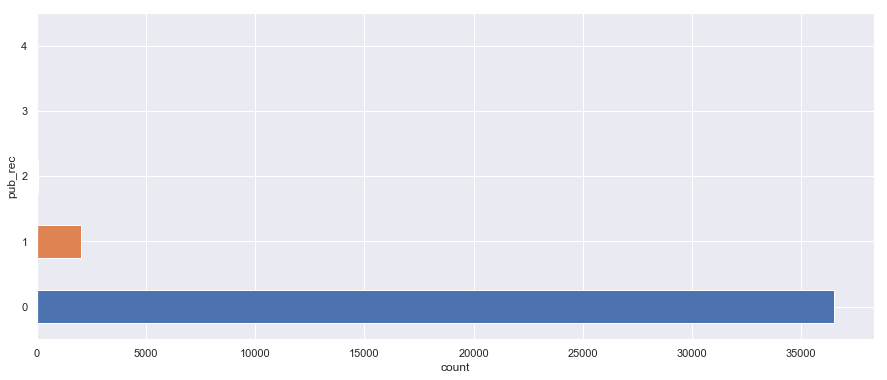

****************************************************************************************************


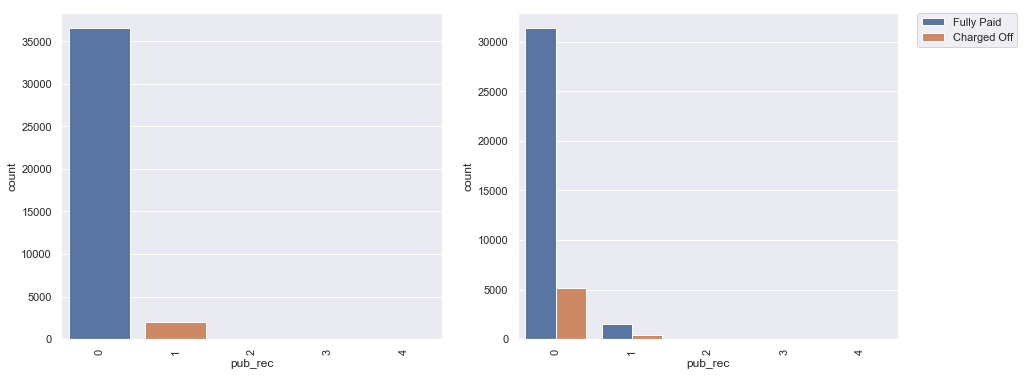

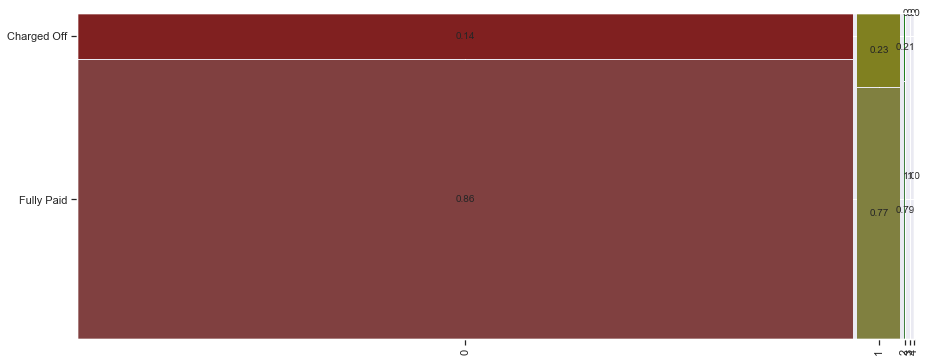

In [65]:
# Doing Univariate analysis 
uni_analysis_cat(loan_df[['pub_rec', 'loan_status']])

Mosaic Plot shows a significant variation between public record 0 and 1 (14% compared to 23% respectively). 

In [66]:
# chi2 test for pub_rec
chi2_cat_pearson(loan_df[['pub_rec','loan_status']])

p value = 4.981860171686025e-24
The 2 data sets are not independent of each other 


Chi2 test also confirms that pub_rec has significant impact on loan status.

In [67]:
# chi2 post-hoc test for pub_rec
chi2_post_hoc(loan_df[['pub_rec','loan_status']])

Bonferroni-adjusted p-value:  0.01
Pairwise comparisons is significant for: value_0
p-value= 6.041257426965279e-26

Pairwise comparisons is significant for: value_1
p-value= 4.370144155806834e-26



post-hoc test confirms that, if the Public record is 1 (or more), there is a high propensity to default

__`pub_rec` is one of the most important variables that Lending club should be interested in to make the decision__

### `pub_rec_bankruptcies`: Number of public record bankruptcies

Even if the values are Numeric, we are considering this to be categorical as only 3 values are available

count    38577.000000
mean         0.042694
std          0.202809
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64


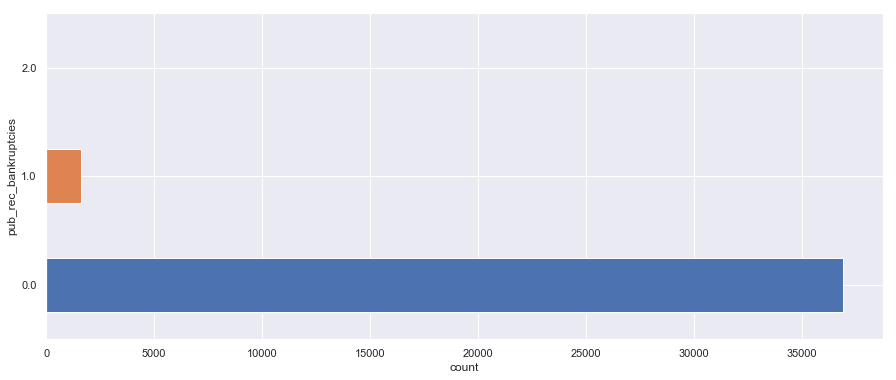

****************************************************************************************************


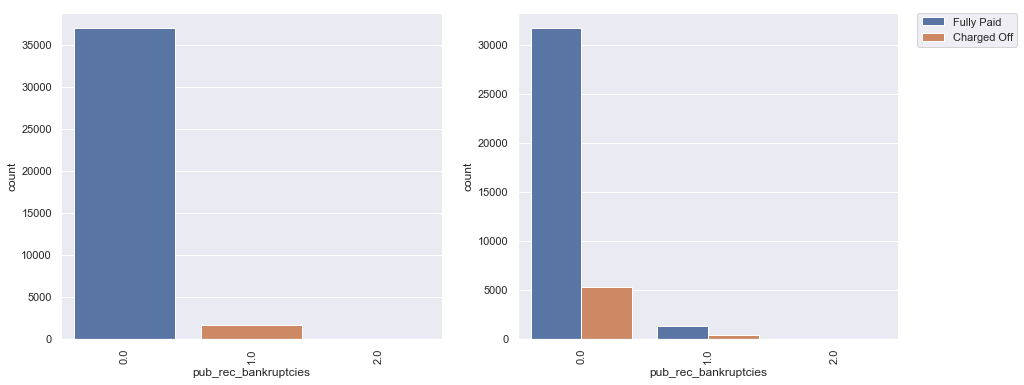

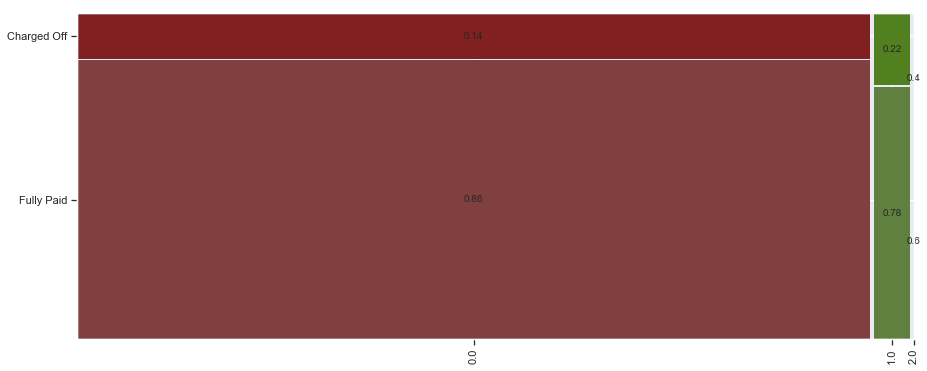

In [68]:
# Doing Univariate analysis 
uni_analysis_cat(loan_df[['pub_rec_bankruptcies', 'loan_status']])

Mosaic Plot shows a significant variation between pub_rec_bankruptcies 0 and 1 (14% compared to 22% respectively). 

In [69]:
# chi2 test for pub_rec_bankruptcies
chi2_cat_pearson(loan_df[['pub_rec_bankruptcies','loan_status']])

p value = 2.6653009609320754e-19
The 2 data sets are not independent of each other 


In [70]:
# chi2 post-hoc test for pub_rec_bankruptcies
chi2_post_hoc(loan_df[['pub_rec_bankruptcies','loan_status']])

Bonferroni-adjusted p-value:  0.016666666666666666
Pairwise comparisons is significant for: value_0.0
p-value= 5.943250117786229e-20

Pairwise comparisons is significant for: value_1.0
p-value= 1.2147979175672216e-19



If the pub_rec_bankruptcies record is 1 or more, there is a high propensity to default

__`pub_rec_bankruptcies` is one of the most important variables that Lending club should be interested in to make the decision__

We'll later check for correlation between `pub_rec` and `pub_rec_bankruptcies` to confirm whether we need to keep both

### `earliest_cr_line`:	The month the borrower's earliest reported credit line was opened

This field is in month-year format. we'll split this month and year to analyze this field

In [71]:
# In case of months , perform analysis based on both month and year 
# start with the setting the date type and then continue with the seperate analysis of Month and year 

loan_df.earliest_cr_line = pd.to_datetime(loan_df.earliest_cr_line , format = '%b-%y')

loan_df['earliest_cr_line_month'] = loan_df.earliest_cr_line.dt.month
# need to take care of the years as transformation resulting in future years
loan_df['earliest_cr_line_year'] = loan_df.earliest_cr_line.dt.year.apply(lambda x: x-100 if x > 2019 else x)

The value of month is numeric, but has been considered as categorical.

count    38577.000000
mean         6.894004
std          3.539057
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: earliest_cr_line_month, dtype: float64


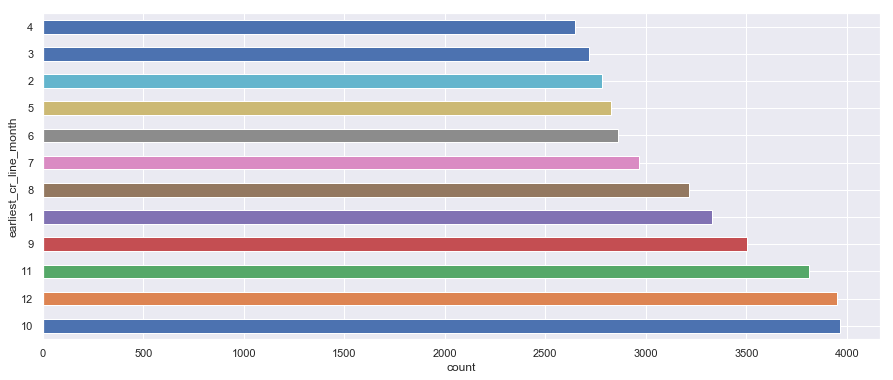

****************************************************************************************************


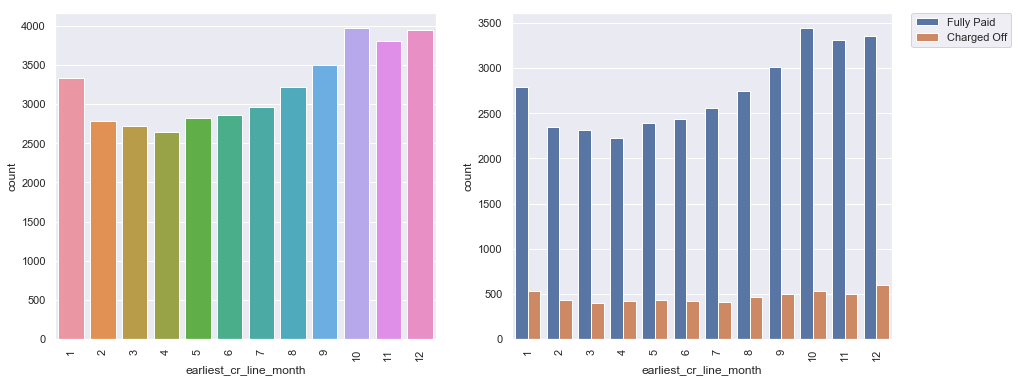

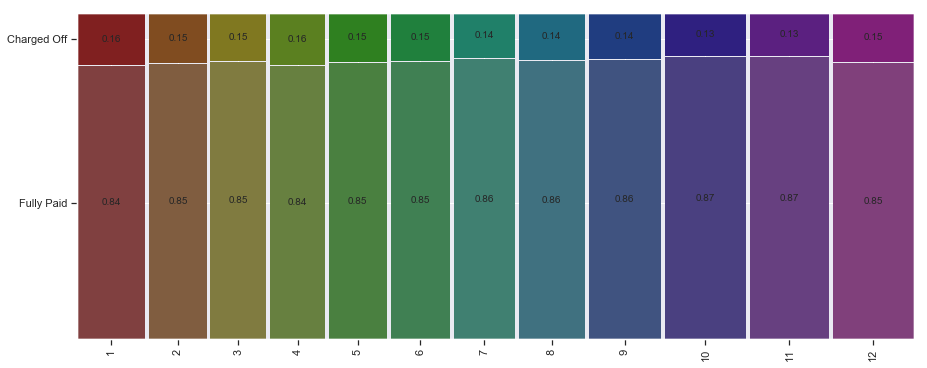

In [72]:
# Univariate analysis considering the month of the earliest credict line 
uni_analysis_cat(loan_df[['earliest_cr_line_month' , 'loan_status']] , summary = True)

In [73]:
# chi2 test for earliest_cr_line_month
chi2_cat_pearson(loan_df[['earliest_cr_line_month','loan_status']])

p value = 0.003569738253808816
The 2 data sets are not independent of each other 


In [74]:
# chi2 post-hoc test for earliest_cr_line_month
chi2_post_hoc(loan_df[['earliest_cr_line_month','loan_status']])

Bonferroni-adjusted p-value:  0.004166666666666667


Mosaic plot does not show a lot of variance between fully paid and charged off for different home ownership statuses.  
Even if chi2 states otherwise, post-hoc test could not identify any particular month as most significant.  
we are NOT considering this to be a significant variable.

count    38577.000000
mean      1996.604816
std          6.815696
min       1946.000000
25%       1993.000000
50%       1998.000000
75%       2001.000000
max       2008.000000
Name: earliest_cr_line_year, dtype: float64


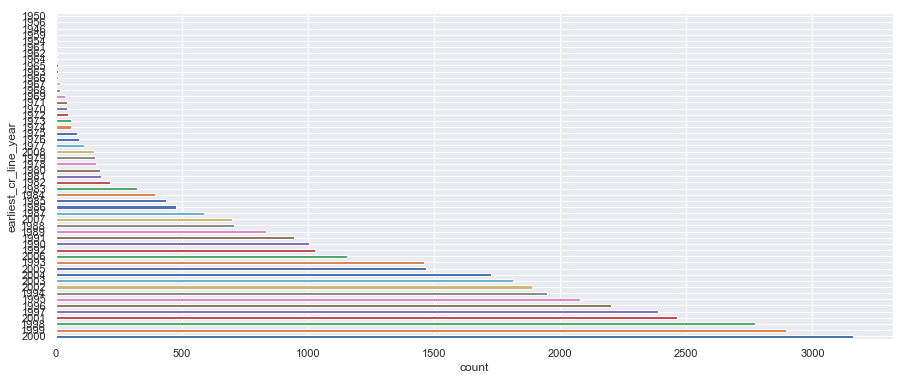

****************************************************************************************************


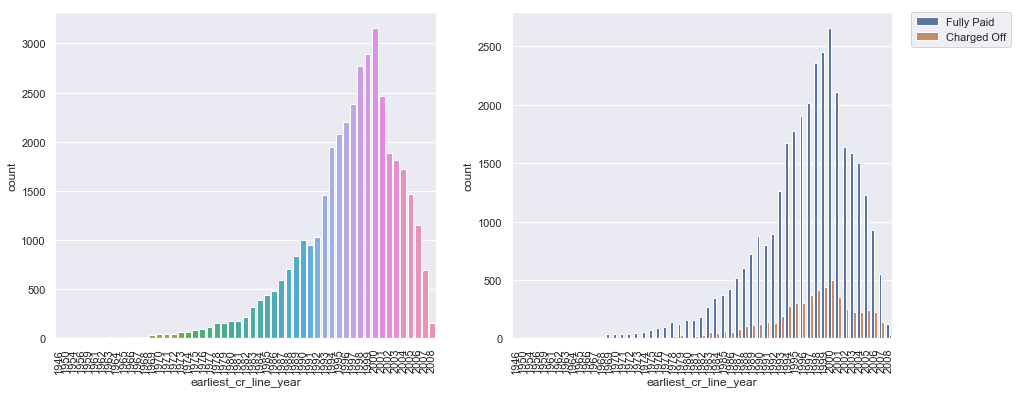

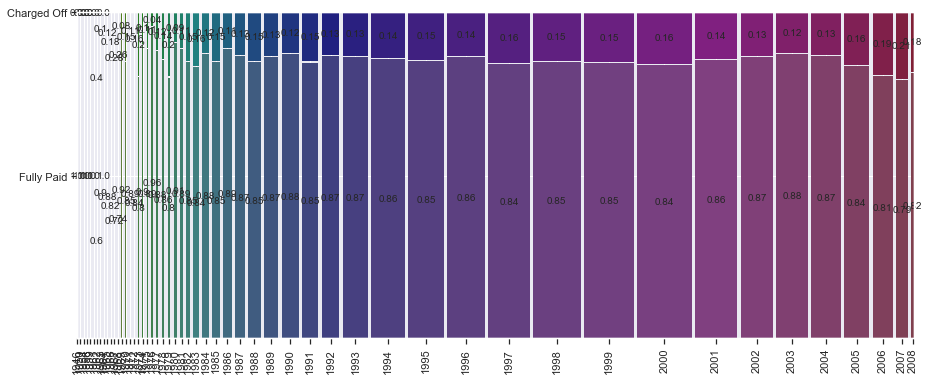

In [75]:
# Univariate analysis considering the year of earliest credit line 
# Here we see that delinquency increases witht the later yeas for growth when loans may have increase just to meet the target numbers

uni_analysis_cat(loan_df[['earliest_cr_line_year' , 'loan_status']])

In [76]:
# chi2 test for earliest_cr_line_year
chi2_cat_pearson(loan_df[['earliest_cr_line_year','loan_status']])

p value = 5.026177549165791e-07
The 2 data sets are not independent of each other 


In [77]:
# chi2 post-hoc test earliest_cr_line_year
chi2_post_hoc(loan_df[['earliest_cr_line_year','loan_status']])

Bonferroni-adjusted p-value:  0.0009433962264150943
Pairwise comparisons is significant for: value_2006
p-value= 2.986471906492874e-06

Pairwise comparisons is significant for: value_2007
p-value= 6.4441344073125414e-06



Mosaic plot shows that proportion of charged off is continusly increasing post 2004.  Both Chi2 and post hoc test confirms that the variable has significant impact on loan status. However Lending Club will not have direct control on this variable.  
However, this can indicate that the process of approving first credit line has deteriorated over due course. 

## Analysis of loan attributes

### `loan_amnt`: The listed amount of the loan applied for by the borrower

count    38577.00
mean     11047.03
std       7348.44
min        500.00
25%       5300.00
50%       9600.00
75%      15000.00
max      35000.00
Name: loan_amnt, dtype: float64
****************************************************************************************************


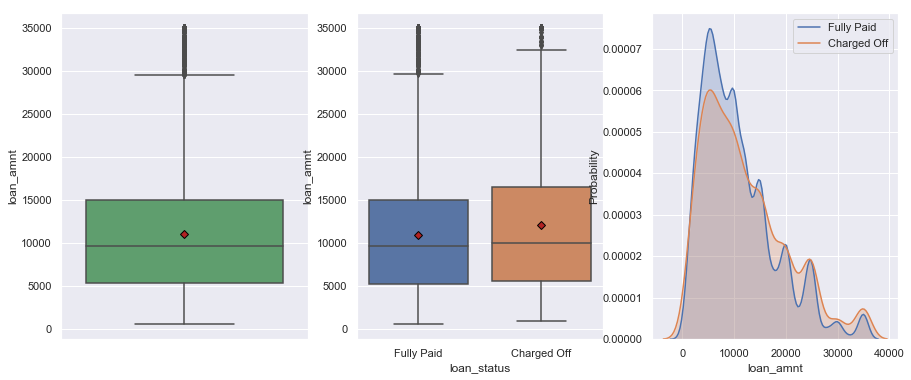

In [78]:
uni_analysis_num(loan_df[['loan_amnt' , 'loan_status']])

In [79]:
# Independent T test for loan_amnt
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].loan_amnt ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].loan_amnt)

p value =  6.987968294434883e-27
The 2 sets of data differ significantly


In [80]:
# Tukey's HSD for loan_amnt
tukeys_hsd(loan_df[['loan_amnt' , 'loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:       Multiple Comparison of Means - Tukey HSD,FWER=0.05      
   group1     group2    meandiff    lower      upper    reject
--------------------------------------------------------------
Charged Off Fully Paid -1237.9291 -1445.3209 -1030.5373  True 
--------------------------------------------------------------
mean diffs: [-1237.92911359]
std pairs: [74.81949795]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The spread for fully paid and charged off loans seams to be same, so distinction cannot be made.  
Even if T test and Tukey's HSD states otherwise, we are NOT considering this to be a significant variable.

### `installment`: The monthly payment owed by the borrower if the loan originates

count    38577.00
mean       322.47
std        208.64
min         15.69
25%        165.74
50%        277.86
75%        425.55
max       1305.19
Name: installment, dtype: float64
****************************************************************************************************


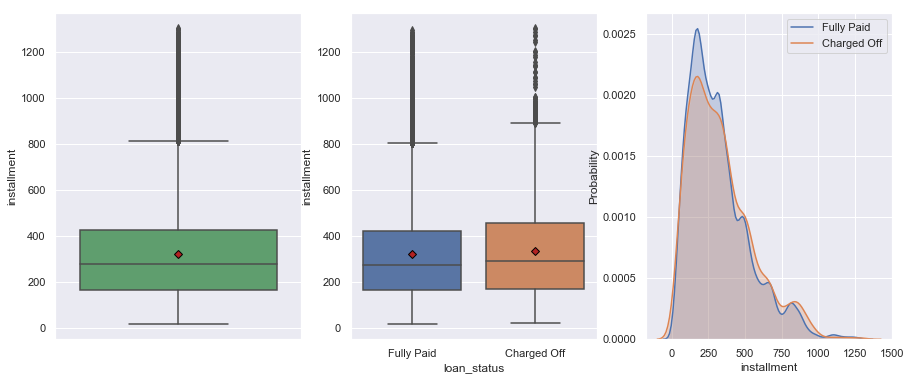

In [81]:
uni_analysis_num(loan_df[['installment' , 'loan_status']])

In [82]:
# Independent T test for installment
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].installment ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].installment)

p value =  2.529850741459151e-07
The 2 sets of data differ significantly


In [83]:
# Tukey's HSD for installment
tukeys_hsd(loan_df[['installment','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1     group2   meandiff  lower    upper   reject
--------------------------------------------------------
Charged Off Fully Paid -16.0498 -21.9464 -10.1532  True 
--------------------------------------------------------
mean diffs: [-16.04977435]
std pairs: [2.12727909]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The spread for fully paid and charged off loans seams to be same, so distinction cannot be made.  
Even if T test and Tukey's HSD states otherwise, we are NOT considering this to be a significant variable.

### `int_rate`: Interest Rate on the loan

count    38577.00
mean        11.93
std          3.69
min          5.42
25%          8.94
50%         11.71
75%         14.38
max         24.40
Name: int_rate, dtype: float64
****************************************************************************************************


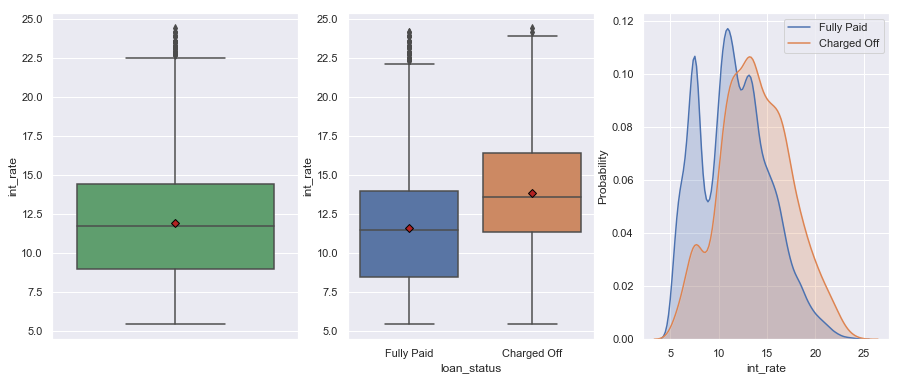

In [84]:
uni_analysis_num(loan_df[['int_rate' , 'loan_status']])

In [85]:
# Independent T test for int_rate
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].int_rate ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].int_rate)

p value =  0.0
The 2 sets of data differ significantly


In [86]:
# Tukey's HSD for int_rate
tukeys_hsd(loan_df[['int_rate','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1     group2   meandiff  lower   upper  reject
------------------------------------------------------
Charged Off Fully Paid -2.2107  -2.3127 -2.1087  True 
------------------------------------------------------
mean diffs: [-2.21067069]
std pairs: [0.03679971]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The median and distribution for fully paid and charged off are significantly different. T-test and Tukey's HSD confirms the claim.

__`int_rate` is one of the most important variables that Lending club should be interested in to make the decision__

### `term`: The number of payments on the loan

term is a numeric value but has been considered as categorical as it has only 2 possible values.

count    38577.000000
mean        41.898437
std         10.333136
min         36.000000
25%         36.000000
50%         36.000000
75%         36.000000
max         60.000000
Name: term, dtype: float64


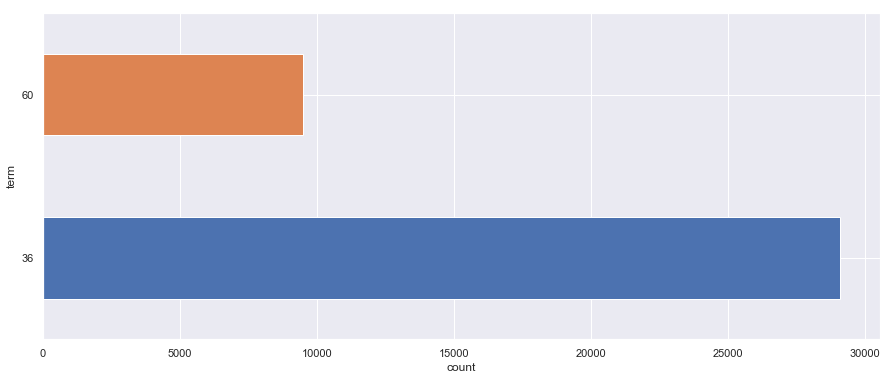

****************************************************************************************************


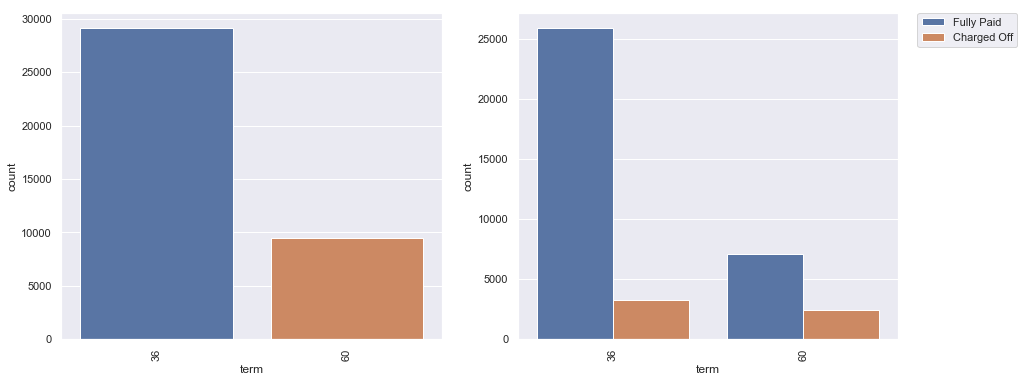

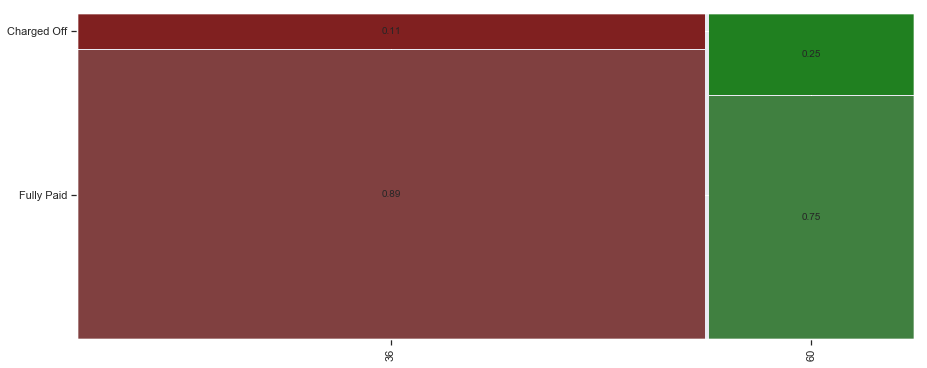

In [87]:
uni_analysis_cat(loan_df[['term' , 'loan_status']])

In [88]:
# chi2 test for term
chi2_cat_pearson(loan_df[['term','loan_status']])

p value = 3.1095440690986406e-254
The 2 data sets are not independent of each other 


In [89]:
# chi2 post-hoc test for term
chi2_post_hoc(loan_df[['term','loan_status']]) 

Bonferroni-adjusted p-value:  0.025
Pairwise comparisons is significant for: value_36
p-value= 3.1095440690986406e-254

Pairwise comparisons is significant for: value_60
p-value= 3.1095440690986406e-254



The mosaic plot show significant difference in proportion for fully paid and charged off numbers for different terms.  
Both ci2 test and post-hoc test indicates the same.

__`term` is one of the most important variables that Lending club should be interested in to make the decision__

### `funded_amnt`: The total amount committed to that loan at that point in time

count    38577.00
mean     10784.06
std       7090.31
min        500.00
25%       5200.00
50%       9550.00
75%      15000.00
max      35000.00
Name: funded_amnt, dtype: float64
****************************************************************************************************


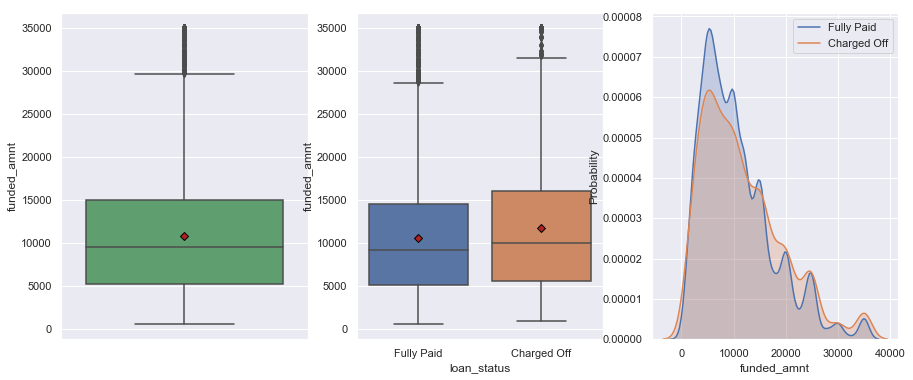

In [90]:
uni_analysis_num(loan_df[['funded_amnt', 'loan_status']])

In [91]:
# Independent T test for funded_amnt
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].funded_amnt ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].funded_amnt)

p value =  1.1937077310061218e-24
The 2 sets of data differ significantly


In [92]:
# Tukey's HSD for funded_amnt
tukeys_hsd(loan_df[['funded_amnt','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:       Multiple Comparison of Means - Tukey HSD,FWER=0.05     
   group1     group2    meandiff    lower      upper   reject
-------------------------------------------------------------
Charged Off Fully Paid -1134.8783 -1335.0193 -934.7373  True 
-------------------------------------------------------------
mean diffs: [-1134.87830596]
std pairs: [72.20369776]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The spread for fully paid and charged off loans seams to be very similar, so distinction is difficult.
Even if T test and Tukey's HSD indicates significant difference in distribution, we are NOT sure regarding the nature of the variable, whether is post loan or pre-loan. We'll take decision on this variable during bi variate analysis.

### `funded_amnt_inv`: The total amount committed by investors for that loan at that point in time

count    38577.00
mean     10222.48
std       7022.72
min          0.00
25%       5000.00
50%       8733.44
75%      14000.00
max      35000.00
Name: funded_amnt_inv, dtype: float64
****************************************************************************************************


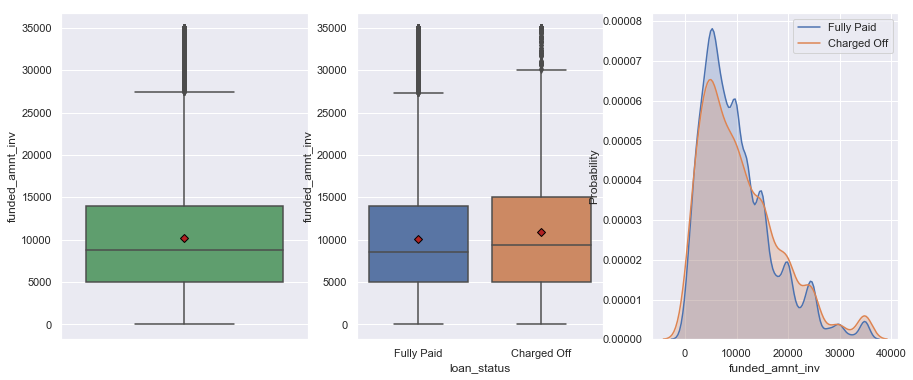

In [93]:
uni_analysis_num(loan_df[['funded_amnt_inv', 'loan_status']])

In [94]:
# Independent T test for annual_income
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].funded_amnt_inv ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].funded_amnt_inv)

p value =  5.755100232747688e-12
The 2 sets of data differ significantly


In [95]:
# Tukey's HSD for funded_amnt_inv
tukeys_hsd(loan_df[['funded_amnt_inv','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:      Multiple Comparison of Means - Tukey HSD,FWER=0.05    
   group1     group2    meandiff   lower     upper   reject
-----------------------------------------------------------
Charged Off Fully Paid -751.6839 -950.0926 -553.2753  True 
-----------------------------------------------------------
mean diffs: [-751.68390995]
std pairs: [71.57871621]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The spread for fully paid and charged off loans seams to be very similar, so distinction is difficult.
Even if T test and Tukey's HSD indicates significant difference in distribution, we are NOT sure regarding the nature of the variable, whether is post loan or pre-loan. We'll take decision on this variable during bi variate analysis.

### `grade`: LC assigned loan grade

count     38577
unique        7
top           B
freq      11675
Name: grade, dtype: object


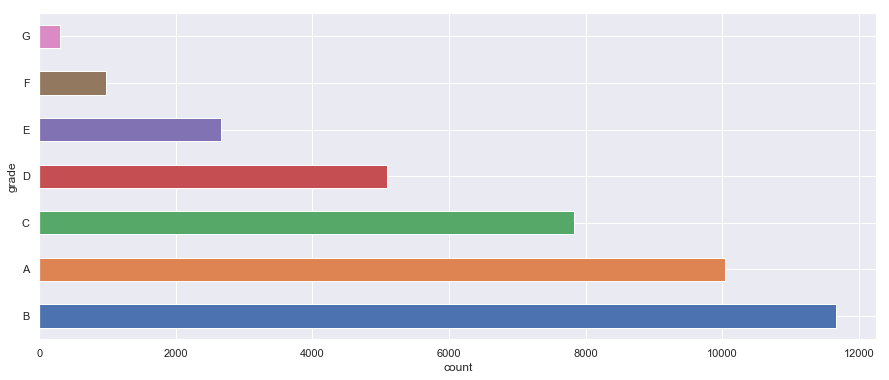

****************************************************************************************************


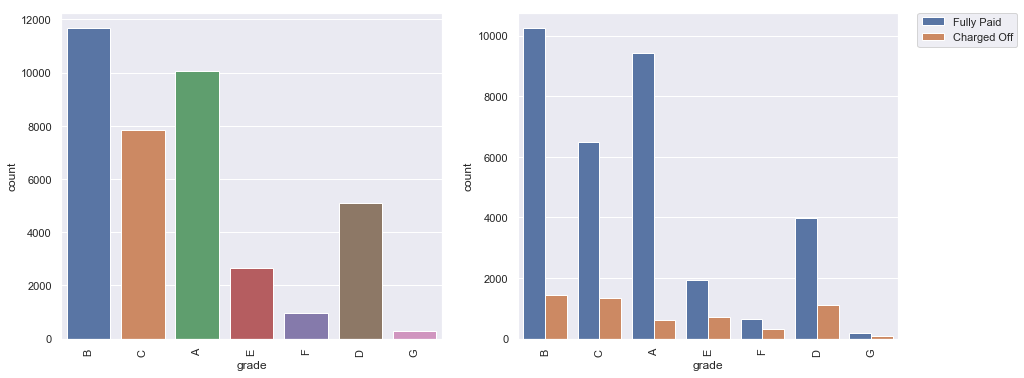

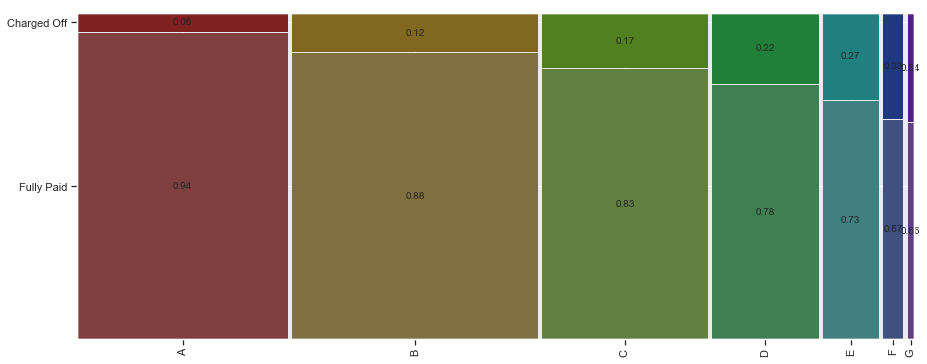

In [96]:
uni_analysis_cat(loan_df[['grade', 'loan_status']])

In [97]:
# chi2 test for grade
chi2_cat_pearson(loan_df[['grade','loan_status']])

p value = 0.0
The 2 data sets are not independent of each other 


In [98]:
# chi2 post-hoc test for grade
chi2_post_hoc(loan_df[['grade','loan_status']])

Bonferroni-adjusted p-value:  0.0071428571428571435
Pairwise comparisons is significant for: A
p-value= 7.022583260169745e-177

Pairwise comparisons is significant for: B
p-value= 2.988844535833408e-18

Pairwise comparisons is significant for: C
p-value= 2.7222448535361206e-13

Pairwise comparisons is significant for: D
p-value= 8.821055822736695e-58

Pairwise comparisons is significant for: E
p-value= 7.72747532970793e-77

Pairwise comparisons is significant for: F
p-value= 7.09417925479254e-59

Pairwise comparisons is significant for: G
p-value= 8.220238222352678e-21



The mosaic plot show significant difference in proportion for fully paid and charged off numbers for different terms.  
Both ci2 test and post-hoc test indicates the same. Post-hoc test identified all values of grade to be very significant.  
However int_rate is decided based on grade and sub grade. - https://www.lendingclub.com/foliofn/rateDetail.action  
As we have already considered int_rate as significant variable, we are NOT considering this to be a significant variable.

### `sub_grade`: LC assigned loan subgrade

count     38577
unique       35
top          A4
freq       2873
Name: sub_grade, dtype: object


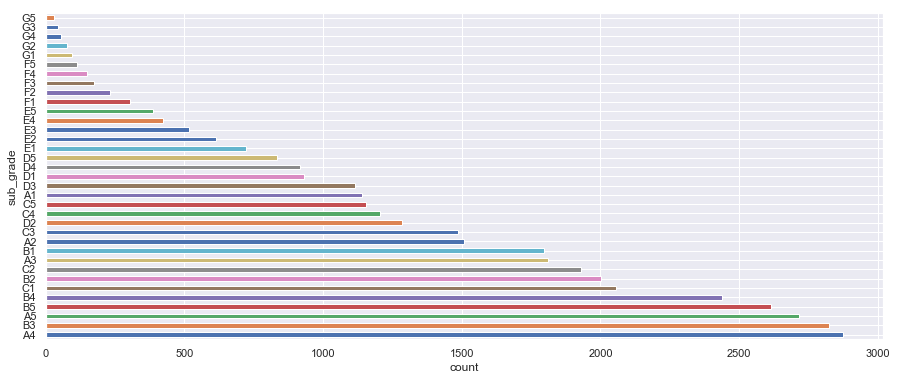

****************************************************************************************************


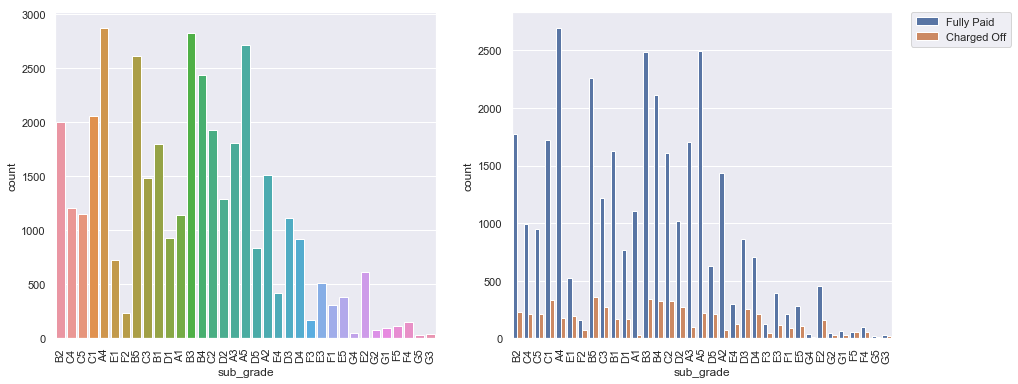

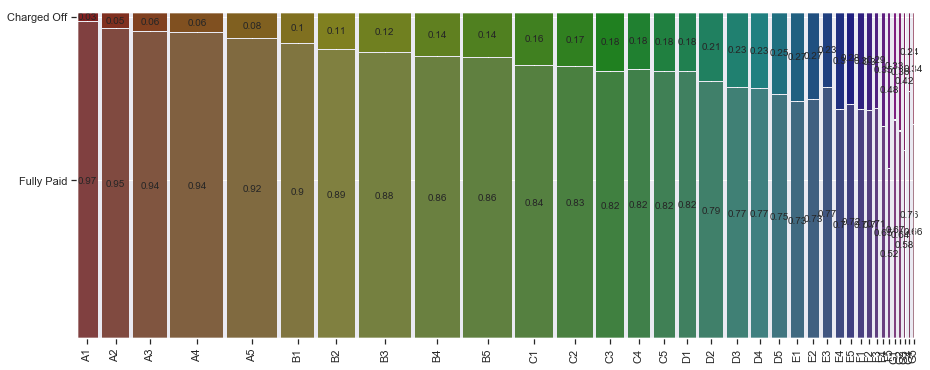

In [99]:
uni_analysis_cat(loan_df[['sub_grade' , 'loan_status']] , summary = True)

In [100]:
# chi2 test for sub_grade
chi2_cat_pearson(loan_df[['sub_grade','loan_status']])

p value = 0.0
The 2 data sets are not independent of each other 


In [101]:
# chi2 post-hoc test for sub_grade
chi2_post_hoc(loan_df[['sub_grade','loan_status']])

Bonferroni-adjusted p-value:  0.0014285714285714286
Pairwise comparisons is significant for: A1
p-value= 6.702925101566454e-31

Pairwise comparisons is significant for: A2
p-value= 2.5886857620110777e-27

Pairwise comparisons is significant for: A3
p-value= 6.724655624906988e-28

Pairwise comparisons is significant for: A4
p-value= 6.987292489745435e-40

Pairwise comparisons is significant for: A5
p-value= 7.704970535922006e-24

Pairwise comparisons is significant for: B1
p-value= 5.560634900266836e-10

Pairwise comparisons is significant for: B2
p-value= 3.754633213158845e-05

Pairwise comparisons is significant for: B3
p-value= 9.337966502422346e-05

Pairwise comparisons is significant for: C3
p-value= 8.529764573279037e-05

Pairwise comparisons is significant for: C5
p-value= 0.0009100563050505273

Pairwise comparisons is significant for: D2
p-value= 2.6866017719760875e-11

Pairwise comparisons is significant for: D3
p-value= 1.4731962343111054e-15

Pairwise comparisons is significa

The mosaic plot show significant difference in proportion for fully paid and charged off numbers for different terms.  
Both ci2 test and post-hoc test indicates the same. Post-hoc test identified a number of values of sub-grade to be very significant.  
However int_rate is decided based on grade and sub grade. - https://www.lendingclub.com/foliofn/rateDetail.action  
As we have already considered int_rate as significant variable, we are NOT considering this to be a significant variable.

### `purpose`: A category provided by the borrower for the loan request

count                  38577
unique                    14
top       debt_consolidation
freq                   18055
Name: purpose, dtype: object


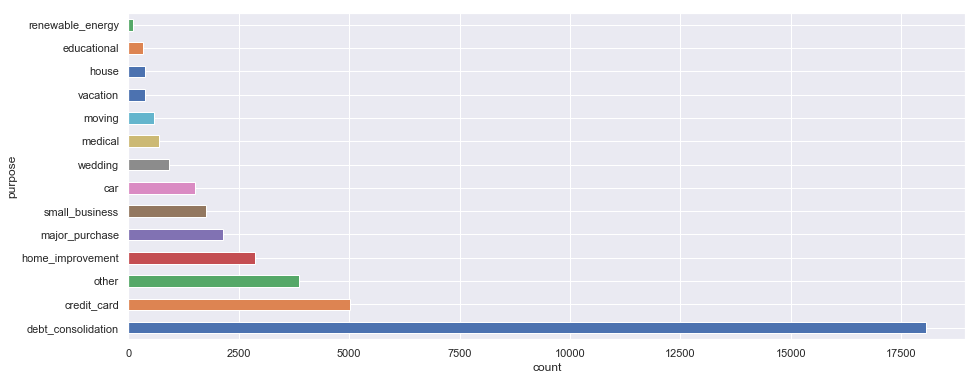

****************************************************************************************************


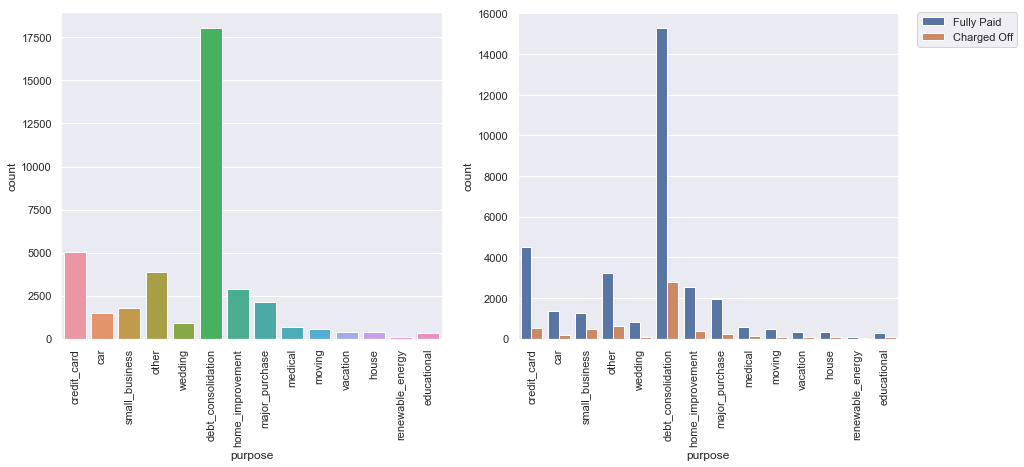

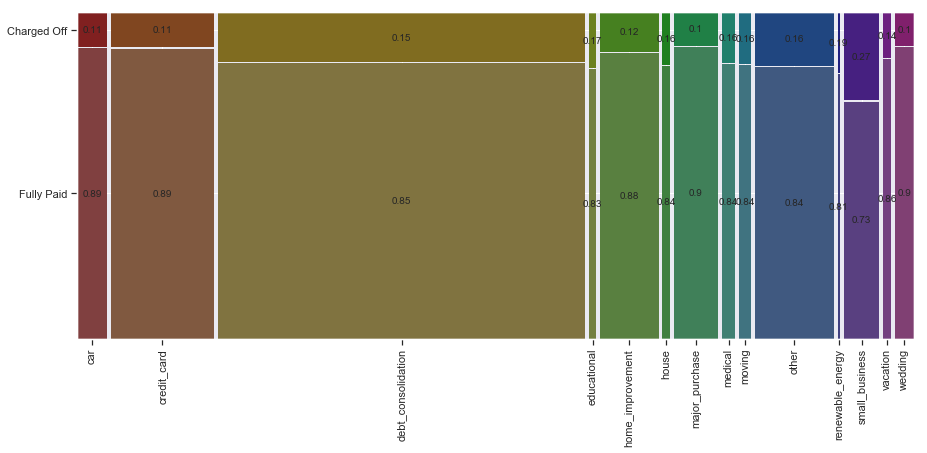

In [102]:
uni_analysis_cat(loan_df[['purpose' , 'loan_status']] , summary = True)

In [103]:
# chi2 test for home_ownership
chi2_cat_pearson(loan_df[['purpose','loan_status']])

p value = 6.213959204644354e-73
The 2 data sets are not independent of each other 


In [104]:
# chi2 post-hoc test for purpose
chi2_post_hoc(loan_df[['purpose','loan_status']])

Bonferroni-adjusted p-value:  0.0035714285714285718
Pairwise comparisons is significant for: car
p-value= 1.422894442424158e-05

Pairwise comparisons is significant for: credit_card
p-value= 2.994491571464397e-16

Pairwise comparisons is significant for: debt_consolidation
p-value= 0.00012176350671763594

Pairwise comparisons is significant for: home_improvement
p-value= 7.920453855875882e-05

Pairwise comparisons is significant for: major_purchase
p-value= 1.0124024172413568e-08

Pairwise comparisons is significant for: other
p-value= 0.0009596158671972481

Pairwise comparisons is significant for: small_business
p-value= 8.894808694557524e-52

Pairwise comparisons is significant for: wedding
p-value= 0.0002781619849605967



The mosaic plot show significant difference in proportion for fully paid and charged off numbers for different terms.  
Both ci2 test and post-hoc test indicates the same.   
We can see that small_business, renewable_energy, educational are purposes where the propensity for default is high.

__`purpose` is an important parameter as it has relevance for Default, we'll consider it as one of the most important variable that Lending Club will be interested in decision making__

### `revol_bal`: Total credit revolving balance

count     38577.00
mean      13289.49
std       15866.49
min           0.00
25%        3650.00
50%        8762.00
75%       16912.00
max      149588.00
Name: revol_bal, dtype: float64
****************************************************************************************************


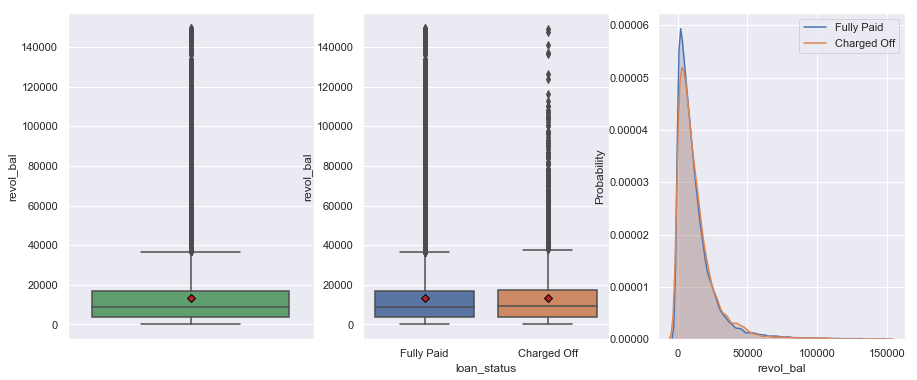

In [105]:
# Doing Univariate analysis 
uni_analysis_num(loan_df[['revol_bal', 'loan_status']])

In [106]:
# Independent T test for revol_bal
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].revol_bal ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].revol_bal)

p value =  0.23275644956697986
We cannot state that the 2 sets of data differ significantly


In [107]:
# Tukey's HSD for revol_bal
tukeys_hsd(loan_df[['revol_bal' , 'loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:     Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1     group2    meandiff   lower    upper  reject
---------------------------------------------------------
Charged Off Fully Paid -263.1359 -711.7149 185.443 False 
---------------------------------------------------------
mean diffs: [-263.1359077]
std pairs: [161.83116934]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: [0.25025467]


The spread for fully paid and charged off loans seams to be same, so distinction cannot be made. T-test and Tukeu's HSD support the claim.

### `revol_util`: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

count    38577.00
mean        48.64
std         28.40
min          0.00
25%         25.10
50%         49.00
75%         72.20
max         99.90
Name: revol_util, dtype: float64
****************************************************************************************************


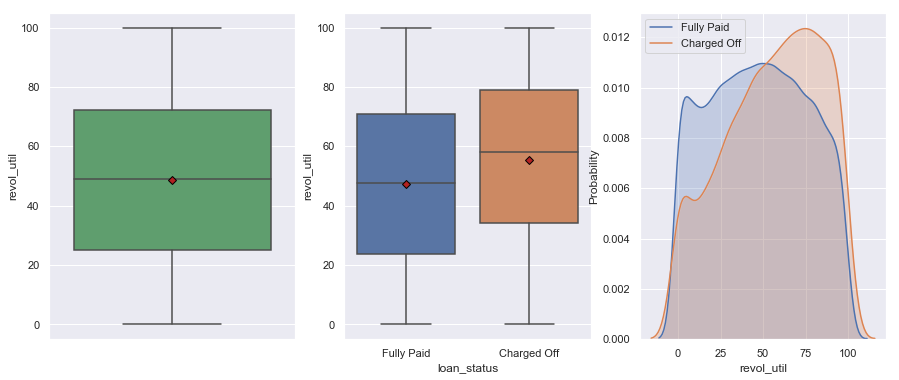

In [108]:
uni_analysis_num(loan_df[['revol_util' , 'loan_status']])


In [109]:
# Independent T test for revol_util
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].revol_util ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].revol_util)

p value =  1.8374326096484966e-83
The 2 sets of data differ significantly


In [110]:
# Tukey's HSD for revol_util
tukeys_hsd(loan_df[['revol_util' , 'loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1     group2   meandiff  lower   upper  reject
------------------------------------------------------
Charged Off Fully Paid -7.9313  -8.7304 -7.1323  True 
------------------------------------------------------
mean diffs: [-7.93133976]
std pairs: [0.28826621]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The mean, median and distribution is significantly different between fully paid and charged off.  
The above test confirms that we can reject the null hypothesis and from the mean difference we can conclude higher the revolving debt utilization higher the chances for customer to default 

__`revol_util` is one of the most important variables that Lending club should be interested in to make the decision__

### `issue_d`: The month which the loan was funded

This is a date variable in month-year form. This will be first split in month and year for further analysis.

In [111]:
# In case of months , perform analysis based on both month and year 
# start with the setting the date type and then continue with the seperate analysis of Month and year 

loan_df.issue_d = pd.to_datetime(loan_df.issue_d , format = '%b-%y')

loan_df['issue_d_month'] = loan_df.issue_d.dt.month
loan_df['issue_d_year'] = loan_df.issue_d.dt.year

#Compress the data for the issue date to display the same in the consolidated form based on % 

df_issue_d = loan_df.loc[loan_df.loan_status == 'Charged Off' , ['issue_d_year' , 'issue_d_month' , 'loan_status']]\
            .groupby(['issue_d_year' , 'issue_d_month' , 'loan_status']).size().reset_index()

df_issue_d['status_percent'] = (df_issue_d[0]/sum(df_issue_d[0])).round(4)*100


month is a numeric values but treated as ordinal.

count    38577.000000
mean         7.114757
std          3.408523
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: issue_d_month, dtype: float64


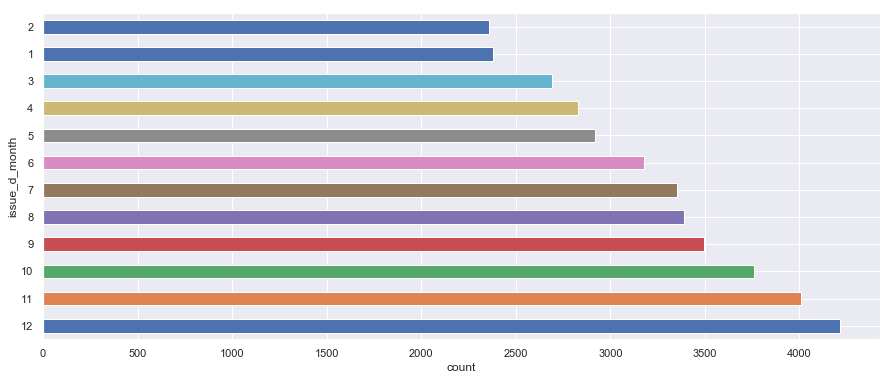

****************************************************************************************************


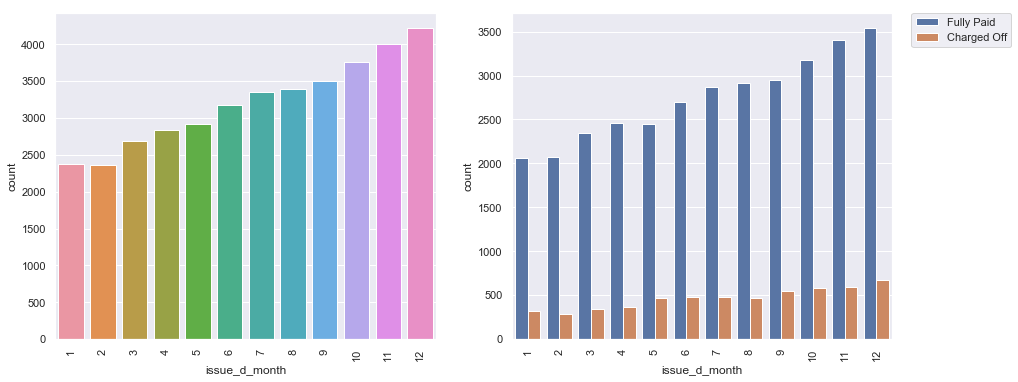

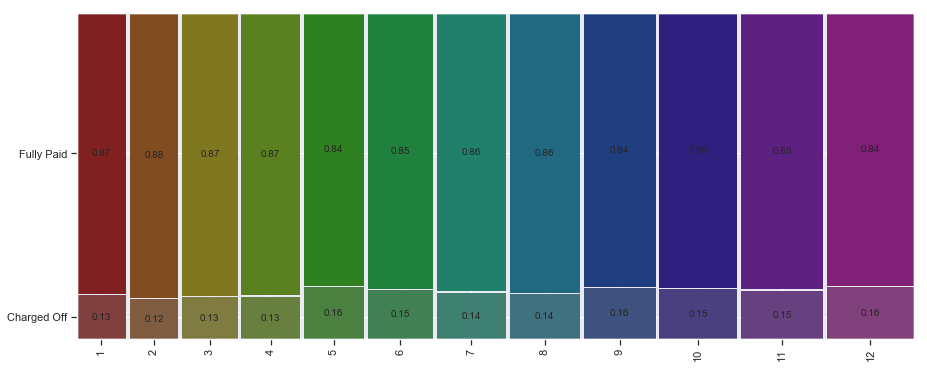

In [112]:
# Univariate analysis considering the month of the loan issue 
# Here we see that delinquency increases witht the later months when loans may have increase just to meet the target numbers

uni_analysis_cat(loan_df[['issue_d_month' , 'loan_status']] , summary = True)

In [113]:
# chi2 test for issue_d_month
chi2_cat_pearson(loan_df[['issue_d_month','loan_status']])

p value = 7.23912235626755e-06
The 2 data sets are not independent of each other 


In [114]:
# chi2 post-hoc test for issue_d_month
chi2_post_hoc(loan_df[['issue_d_month','loan_status']]) 

Bonferroni-adjusted p-value:  0.004166666666666667
Pairwise comparisons is significant for: value_2
p-value= 0.0012899303497380553

Pairwise comparisons is significant for: value_12
p-value= 0.003752456732247665



Mosaic plot does not show a lot of variance between fully paid and charged off for different issue month.  
Even if chi2 and post-hoc states otherwise, we are NOT considering this to be a significant variable.

count    38577.000000
mean      2010.309070
std          0.882658
min       2007.000000
25%       2010.000000
50%       2011.000000
75%       2011.000000
max       2011.000000
Name: issue_d_year, dtype: float64


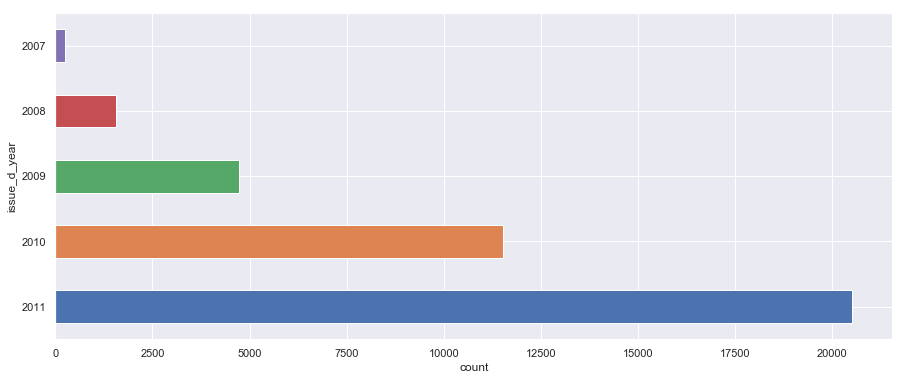

****************************************************************************************************


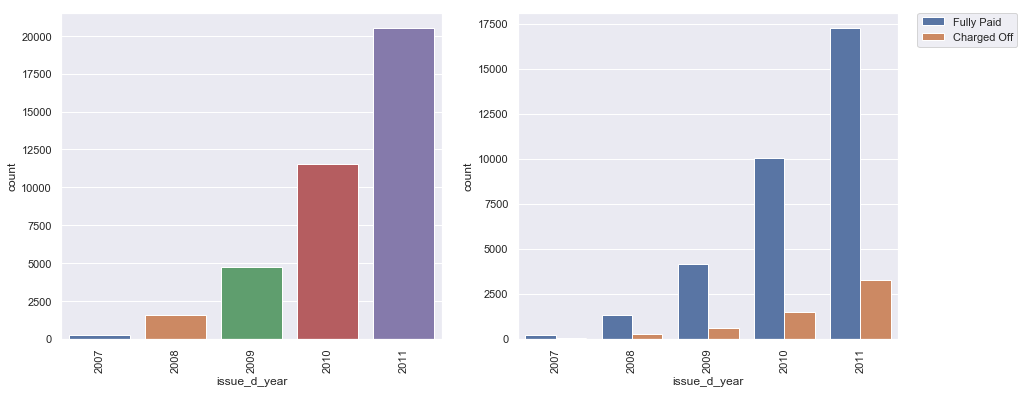

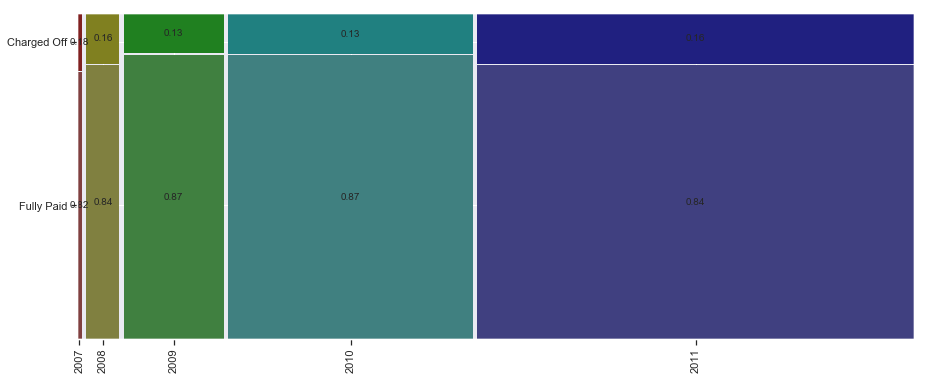

In [115]:
# Univariate analysis considering the year of the loan issue 
uni_analysis_cat(loan_df[['issue_d_year' , 'loan_status']])

In [116]:
# chi2 test for issue_d_year
chi2_cat_pearson(loan_df[['issue_d_year','loan_status']])

p value = 4.479776077418912e-15
The 2 data sets are not independent of each other 


In [117]:
# chi2 post-hoc test for issue_d_year
chi2_post_hoc(loan_df[['issue_d_year','loan_status']]) 

Bonferroni-adjusted p-value:  0.01
Pairwise comparisons is significant for: value_2009
p-value= 3.912653125173958e-05

Pairwise comparisons is significant for: value_2010
p-value= 5.836999954795818e-10

Pairwise comparisons is significant for: value_2011
p-value= 2.932681990336972e-14



Mosaic plot shows that proportion of charged off is higher in 2007, 2008 and 2011.  Both Chi2 and post hoc test confirms that the variable has significant impact on loan status. However Lending Club will not have direct control on this variable.  
However, this can indicate that the process of issuing loan is not always efficient. 

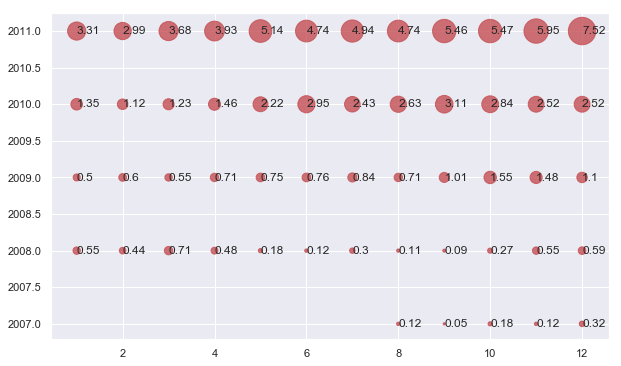

In [118]:
# Undertake the scatter plot for the charged Off variables

bubble_plot(df_issue_d.issue_d_month , df_issue_d.issue_d_year , df_issue_d.loan_status , df_issue_d.status_percent)

Here we see that delinquency increases witht the later yeas for growth when loans may have increase just to meet the target numbers.

### `inq_last_6mths`: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

This value is numeric, but treated as categorical as there are only 8 values.

count    38577.000000
mean         0.871737
std          1.071546
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: inq_last_6mths, dtype: float64


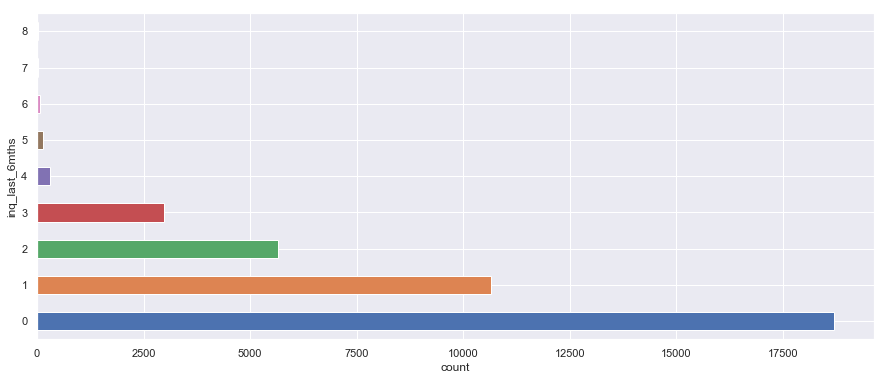

****************************************************************************************************


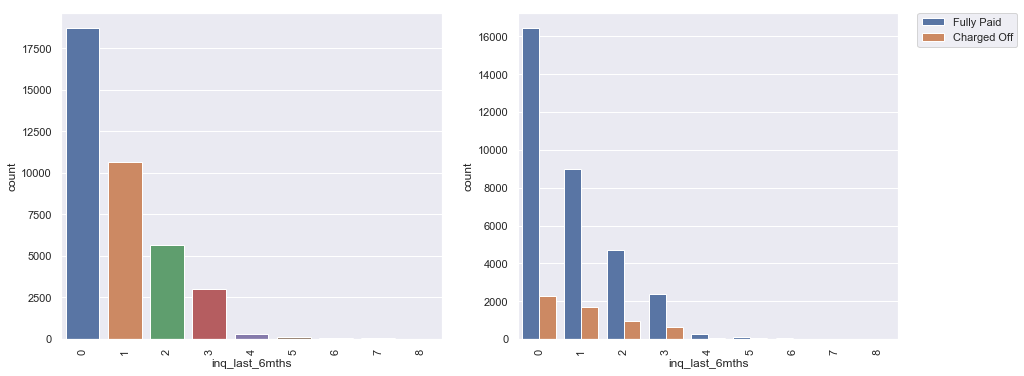

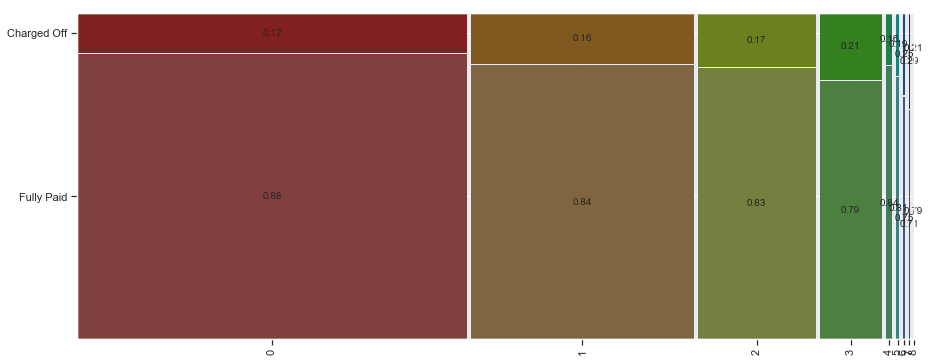

In [119]:
uni_analysis_cat(loan_df[['inq_last_6mths' , 'loan_status']])

In [120]:
# chi2 test for inq_last_6mths
chi2_cat_pearson(loan_df[['inq_last_6mths','loan_status']])

p value = 4.696844118965622e-44
The 2 data sets are not independent of each other 


In [121]:
# chi2 post-hoc test for inq_last_6mths
chi2_post_hoc(loan_df[['inq_last_6mths','loan_status']]) 

Bonferroni-adjusted p-value:  0.005555555555555556
Pairwise comparisons is significant for: value_0
p-value= 2.5496544301798476e-38

Pairwise comparisons is significant for: value_1
p-value= 8.782182557162125e-05

Pairwise comparisons is significant for: value_2
p-value= 1.5567070979659734e-06

Pairwise comparisons is significant for: value_3
p-value= 4.0267804222166465e-23



The mosaic plot show significant difference in proportion for fully paid and charged off numbers for different levels of inquiries.  
Both ci2 test and post-hoc test indicates the same. post hoc test indicates value greater that risk has potential risk for delinquency. This can be used by Lending Club to assess risk of delinquency.

__`inq_last_6mths` is one of the most important variables that Lending club should be interested in to make the decision__

## Derived Metrics

### Monthly income - binned 

The purpose of the derived variable is create bins for monthly income can visualize the same as categorical variable and the establish the same claim that annual income is one of the most significant variables

In [122]:
# annual income to monthly income
loan_df['monthly_inc'] =  loan_df.annual_inc/12
loan_df['monthly_inc'].describe()

count     38577.000000
mean       5731.497807
std        5351.556817
min         333.333333
25%        3333.333333
50%        4905.666667
75%        6833.333333
max      500000.000000
Name: monthly_inc, dtype: float64

count         38577
unique           12
top       4000-5000
freq           6989
Name: monthly_inc_bins, dtype: object


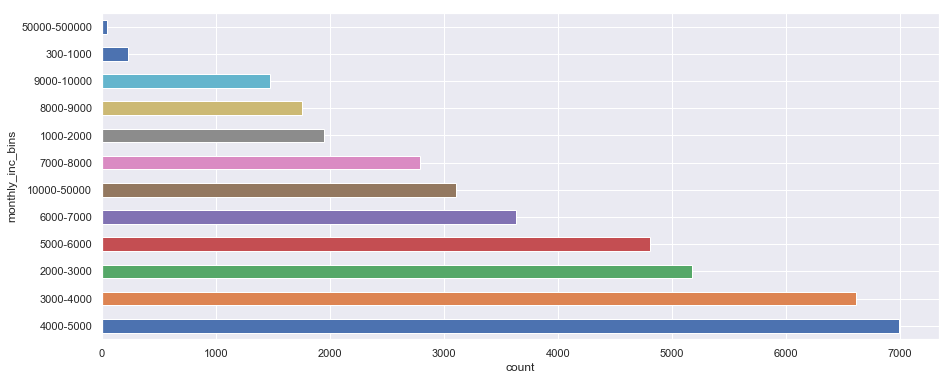

****************************************************************************************************


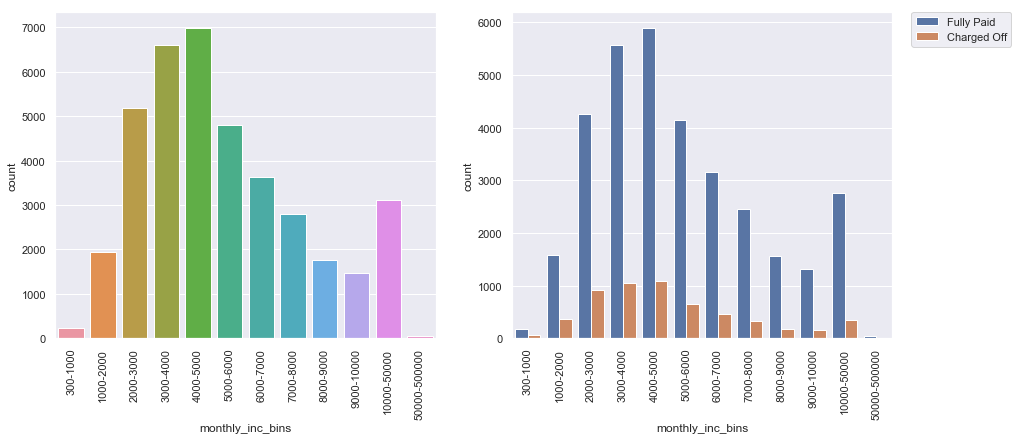

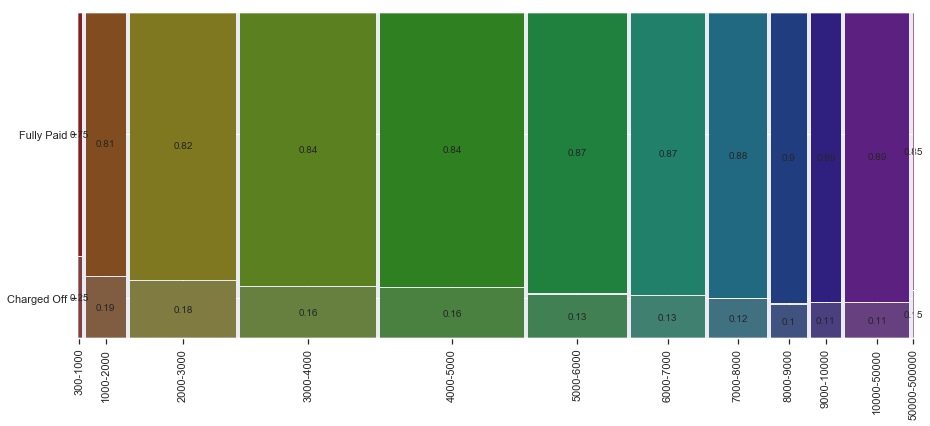

In [123]:
# bins to be created
bins = [300, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 50000, 500000]
# bin labels
labels = ['300-1000', 
          '1000-2000', 
          '2000-3000', 
          '3000-4000', 
          '4000-5000', 
          '5000-6000', 
          '6000-7000', 
          '7000-8000', 
          '8000-9000', 
          '9000-10000', 
          '10000-50000', 
          '50000-500000']
loan_df['monthly_inc_bins'] =  pd.cut(loan_df.monthly_inc, bins = bins, labels=labels)
uni_analysis_cat(loan_df[['monthly_inc_bins', 'loan_status']])

In [124]:
# chi2 test for monthly_inc_bins
chi2_cat_pearson(loan_df[['monthly_inc_bins','loan_status']])

p value = 7.481651059497272e-38
The 2 data sets are not independent of each other 


In [125]:
# chi2 post-hoc test for issue_d_year
chi2_post_hoc(loan_df[['monthly_inc_bins','loan_status']]) 

Bonferroni-adjusted p-value:  0.004166666666666667
Pairwise comparisons is significant for: value_300-1000
p-value= 1.0146918588620985e-05

Pairwise comparisons is significant for: value_1000-2000
p-value= 1.8779029559329235e-08

Pairwise comparisons is significant for: value_2000-3000
p-value= 6.096611110256699e-12

Pairwise comparisons is significant for: value_3000-4000
p-value= 0.002388769692134613

Pairwise comparisons is significant for: value_6000-7000
p-value= 0.003338113767493308

Pairwise comparisons is significant for: value_7000-8000
p-value= 0.00010000506633910018

Pairwise comparisons is significant for: value_8000-9000
p-value= 5.224096635617421e-07

Pairwise comparisons is significant for: value_9000-10000
p-value= 4.814467903599373e-05

Pairwise comparisons is significant for: value_10000-50000
p-value= 3.483193475947515e-09



mosaic plots, chi2 test and post hoc test confirms that monthly income bins and in turn annual income as significant impact of delinquency. There is no need to select this variable as this derived from annual income straightway.

### Loan Amount as Percentage of Annual Income

count    38577.00
mean        18.58
std         11.52
min          0.08
25%          9.80
50%         16.30
75%         25.00
max         83.00
Name: loan_amount_by_annual_inc, dtype: float64
****************************************************************************************************


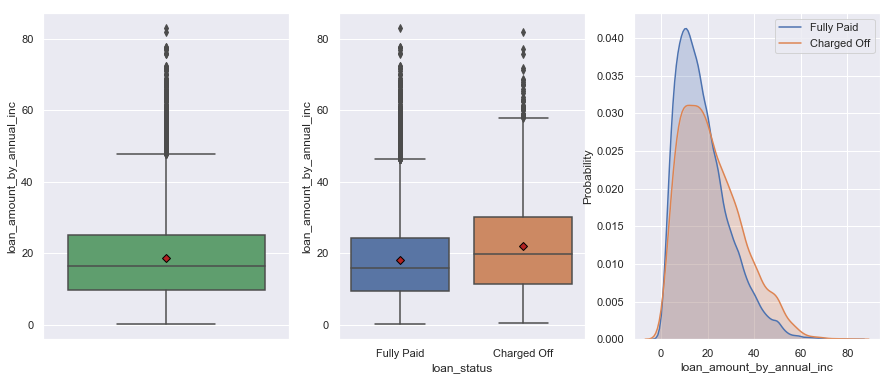

In [126]:
# % of loan amount with respect to annual inc
loan_df['loan_amount_by_annual_inc'] = loan_df.loan_amnt/loan_df.annual_inc*100
uni_analysis_num(loan_df[['loan_amount_by_annual_inc', 'loan_status']])

In [127]:
# Independent T test for loan_amount_by_annual_inc
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].loan_amount_by_annual_inc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].loan_amount_by_annual_inc)

p value =  1.0005620203558989e-94
The 2 sets of data differ significantly


In [128]:
# Tukey's HSD for loan_amount_by_annual_inc
tukeys_hsd(loan_df[['loan_amount_by_annual_inc','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1     group2   meandiff  lower   upper  reject
------------------------------------------------------
Charged Off Fully Paid -3.8562  -4.1798 -3.5327  True 
------------------------------------------------------
mean diffs: [-3.85624544]
std pairs: [0.11672164]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The mean, median and distribution is significantly different between fully paid and charged off.  
The above test confirms that we can reject the null hypothesis and from the mean difference we can conclude higher the ration between loan_amount and annual_inc higher the chances for customer to default 

__`loan_amount_by_annual_inc` is one of the most important variables that Lending club should be interested in to make the decision__

### Annual Installment as Percentage of Annual Income

count    38577.00
mean         6.56
std          4.01
min          0.03
25%          3.50
50%          5.77
75%          8.81
max         32.03
Name: annual_installment_by_annual_inc, dtype: float64
****************************************************************************************************


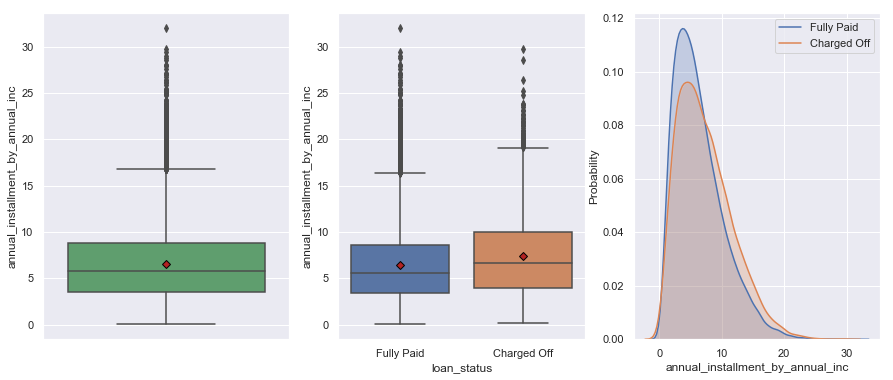

In [129]:
# % of loan installment with respect to monthly income
loan_df['annual_installment_by_annual_inc'] = ((loan_df.installment * 12)/loan_df.annual_inc)*100
uni_analysis_num(loan_df[['annual_installment_by_annual_inc', 'loan_status']])

In [130]:
# Independent T test for annual_installment_by_annual_inc
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].annual_installment_by_annual_inc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].annual_installment_by_annual_inc)

p value =  2.3257532475301674e-53
The 2 sets of data differ significantly


In [131]:
# Tukey's HSD for annual_installment_by_annual_inc
tukeys_hsd(loan_df[['annual_installment_by_annual_inc','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1     group2   meandiff  lower   upper  reject
------------------------------------------------------
Charged Off Fully Paid -0.9494  -1.0622 -0.8365  True 
------------------------------------------------------
mean diffs: [-0.94936125]
std pairs: [0.04071116]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The mean, median and distribution is significantly different between fully paid and charged off.  
The above test confirms that we can reject the null hypothesis and from the mean difference we can conclude higher the ration between annual installment and annual_inc higher the chances for customer to default 

__`annual_installment_by_annual_inc` is one of the most important variables that Lending club should be interested in to make the decision__

### Surplus amount per month without considering current loan installment

count     38577.00
mean       5014.17
std        5144.29
min         294.98
25%        2895.33
50%        4151.50
75%        5969.34
max      499950.00
Name: surplus_amount_per_month, dtype: float64
****************************************************************************************************


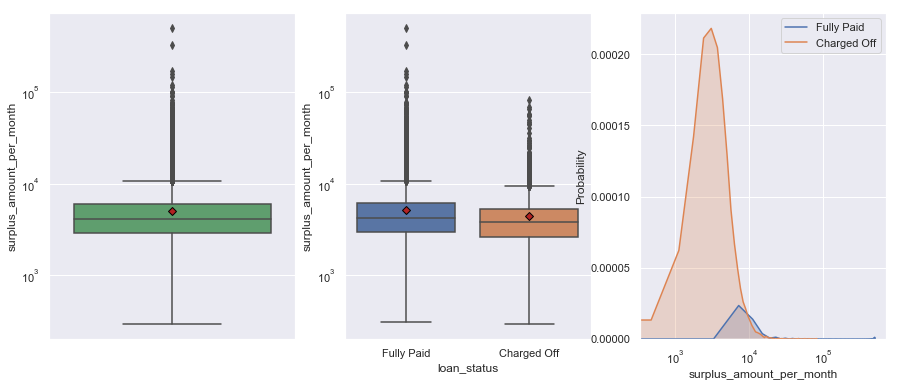

In [132]:
# Surplus amount per month without considering current loan installment
loan_df['surplus_amount_per_month'] = (1 - (loan_df.dti/100)) * loan_df.annual_inc/12
uni_analysis_num(loan_df[['surplus_amount_per_month', 'loan_status']], log_scale=True)

In [133]:
# Independent T test for surplus_amount_per_month
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].surplus_amount_per_month ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].surplus_amount_per_month)

p value =  1.553105567972497e-26
The 2 sets of data differ significantly


In [134]:
# Tukey's HSD for surplus_amount_per_month
tukeys_hsd(loan_df[['surplus_amount_per_month','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1     group2   meandiff  lower    upper   reject
--------------------------------------------------------
Charged Off Fully Paid 604.9684 459.6514 750.2853  True 
--------------------------------------------------------
mean diffs: [604.968382]
std pairs: [52.42513254]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The mean, median and distribution is significantly different between fully paid and charged off.  
The above test confirms that we can reject the null hypothesis and from the mean difference we can conclude lesser the surplus amount higher the chances for customer to default 

__`surplus_amount_per_month` is one of the most important variables that Lending club should be interested in to make the decision__

### Funded amount as proportion to Loan amount

count    38577.00
mean         0.99
std          0.07
min          0.10
25%          1.00
50%          1.00
75%          1.00
max          1.00
Name: funded_amnt_by_loan_amnt, dtype: float64
****************************************************************************************************


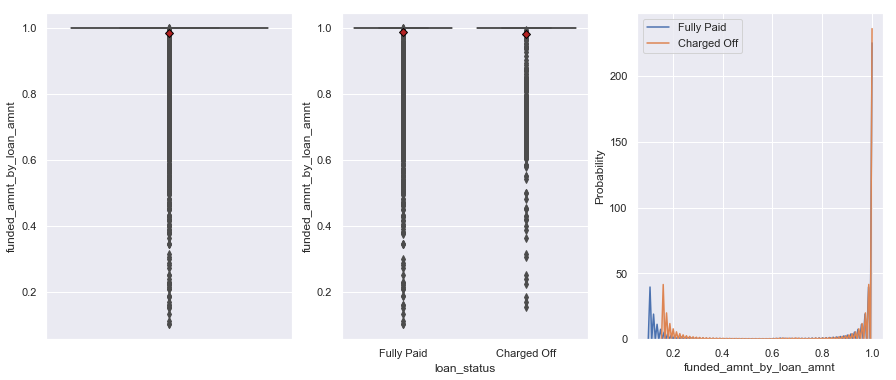

In [135]:
loan_df['funded_amnt_by_loan_amnt'] = loan_df.funded_amnt/loan_df.loan_amnt
uni_analysis_num(loan_df[['funded_amnt_by_loan_amnt', 'loan_status']])

In [136]:
# Independent T test for funded_amnt_by_loan_amnt
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].funded_amnt_by_loan_amnt ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].funded_amnt_by_loan_amnt)

p value =  0.0005724656935536146
The 2 sets of data differ significantly


In [137]:
# Tukey's HSD for funded_amnt_by_loan_amnt
tukeys_hsd(loan_df[['funded_amnt_by_loan_amnt','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
   group1     group2   meandiff lower  upper  reject
----------------------------------------------------
Charged Off Fully Paid  0.0038  0.0018 0.0057  True 
----------------------------------------------------
mean diffs: [0.00377713]
std pairs: [0.00070971]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The spread for fully paid and charged off loans seams to be same, distinction is difficult.  
Even if T test and Tukey's HSD states otherwise, we are NOT considering this to be a significant variable.

### Open_acc in proportion of total_acc

In [138]:
# derived matrix based on open_acc and total_acc
loan_df['open_acc_by_total_acc'] = loan_df.open_acc/loan_df.total_acc

count    38577.00
mean         0.47
std          0.19
min          0.05
25%          0.33
50%          0.44
75%          0.58
max          1.75
Name: open_acc_by_total_acc, dtype: float64
****************************************************************************************************


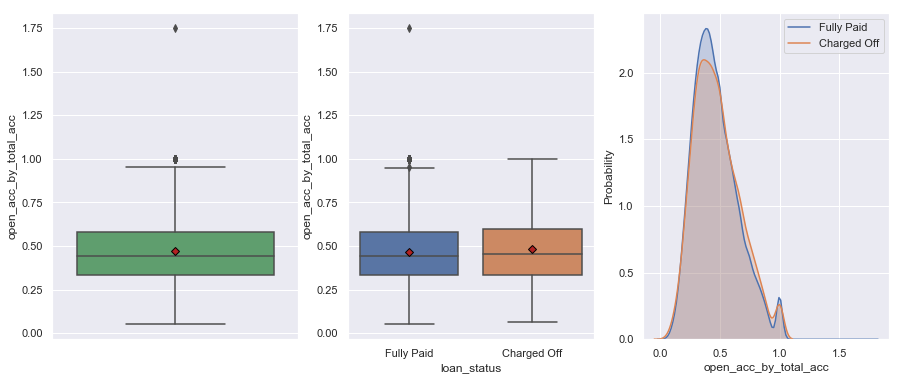

In [139]:
uni_analysis_num(loan_df[['open_acc_by_total_acc', 'loan_status']])

In [140]:
# Independent T test for open_acc_by_total_acc
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].open_acc_by_total_acc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].open_acc_by_total_acc)

p value =  6.386670108070563e-06
The 2 sets of data differ significantly


In [141]:
# Tukey's HSD for open_acc_by_total_acc
tukeys_hsd(loan_df[['open_acc_by_total_acc','loan_status']])

Using the pairwise_tukeyhsd Method
----------------------------------------------------------
summary:   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1     group2   meandiff  lower   upper  reject
------------------------------------------------------
Charged Off Fully Paid -0.0125  -0.0178 -0.0072  True 
------------------------------------------------------
mean diffs: [-0.01247565]
std pairs: [0.00190323]
groups unique:  ['Charged Off' 'Fully Paid']
df total: 38575
p values: 0.001


The derived matrix open_acc_by_total_acc suggest nothing in particular, as distribution is similar to open_acc 

## Bivariate Analysis

### Correlation Analysis

We'll now perform correlation analysis on all numeric values including the derived metrics. This will also include numeric variables that have been considered as categorical for univariate analysis

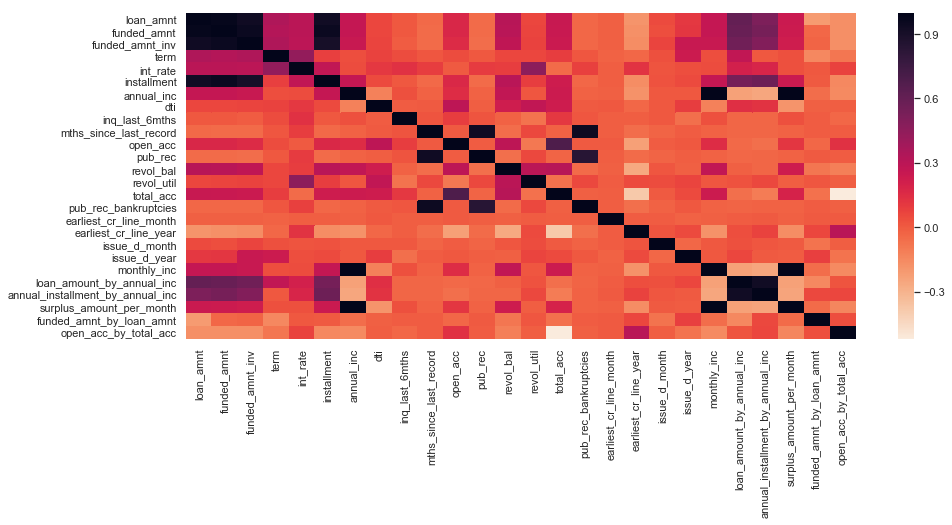

In [142]:
# this is correlation plot for all numeric variables
sns.heatmap(loan_df.corr(), cmap = sns.cm.rocket_r)

In [143]:
loan_df.corr().style.background_gradient()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,inq_last_6mths,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,earliest_cr_line_month,earliest_cr_line_year,issue_d_month,issue_d_year,monthly_inc,loan_amount_by_annual_inc,annual_installment_by_annual_inc,surplus_amount_per_month,funded_amnt_by_loan_amnt,open_acc_by_total_acc
loan_amnt,1,0.98179,0.937922,0.34665,0.301265,0.93226,0.268999,0.0624358,0.01294,-0.0440968,0.1772,-0.0499975,0.314022,0.065247,0.256179,-0.0351408,-0.0133517,-0.182124,0.0519024,0.109814,0.268999,0.603514,0.513583,0.242281,-0.210794,-0.168757
funded_amnt,0.98179,1,0.956172,0.324893,0.30493,0.958035,0.264798,0.0621941,0.0128569,-0.0450441,0.175682,-0.0505762,0.306501,0.0690917,0.250551,-0.0361889,-0.0123696,-0.17526,0.0418525,0.120844,0.264798,0.591587,0.538834,0.238248,-0.0359879,-0.164224
funded_amnt_inv,0.937922,0.956172,1,0.343922,0.297473,0.905464,0.251981,0.070663,-0.00280027,-0.0471814,0.162738,-0.0514702,0.286265,0.0740798,0.242715,-0.036327,-0.0119546,-0.159879,0.0680913,0.252332,0.251981,0.56139,0.501254,0.225761,-0.0232089,-0.169103
term,0.34665,0.324893,0.343922,1,0.440206,0.0904558,0.0438658,0.076182,0.0477079,0.0148981,0.0461625,0.0102661,0.0664109,0.0666585,0.0961683,0.0166903,-0.0155335,-0.0378997,0.0331732,0.237704,0.0438658,0.278372,0.0122213,0.0339554,-0.145432,-0.0807544
int_rate,0.301265,0.30493,0.297473,0.440206,1,0.277203,0.0488991,0.110913,0.133362,0.0942669,0.00602205,0.0986354,0.0941787,0.463627,-0.046539,0.0840158,-0.00764925,0.128793,0.0252851,0.0394166,0.0488991,0.20831,0.183388,0.033912,0.00943124,0.0745495
installment,0.93226,0.958035,0.905464,0.0904558,0.277203,1,0.267842,0.0520385,0.0110144,-0.0411206,0.172893,-0.0457055,0.309501,0.0945593,0.22986,-0.0330383,-0.00903313,-0.15999,0.0294385,0.0530656,0.267842,0.544149,0.575109,0.241758,0.00524981,-0.140211
annual_inc,0.268999,0.264798,0.251981,0.0438658,0.0488991,0.267842,1,-0.12153,0.0354651,-0.0176706,0.156927,-0.017864,0.277374,0.0174974,0.234534,-0.0159546,-0.0101486,-0.179638,0.00897959,0.00855806,1,-0.234338,-0.250297,0.995452,-0.0514364,-0.147425
dti,0.0624358,0.0621941,0.070663,0.076182,0.110913,0.0520385,-0.12153,1,0.00217837,0.00437102,0.287849,-0.00474244,0.22809,0.279091,0.229119,0.00731548,0.00884497,-0.0384346,0.0141972,0.0928568,-0.12153,0.143369,0.129772,-0.185798,-0.0101215,-0.00542513
inq_last_6mths,0.01294,0.0128569,-0.00280027,0.0477079,0.133362,0.0110144,0.0354651,0.00217837,1,0.0209267,0.0934343,0.0237263,-0.020787,-0.0700162,0.113516,0.014821,-0.00726957,-0.0082041,0.0133562,-0.0594955,0.0354651,-0.0273672,-0.0281913,0.0335096,-0.00320197,-0.0350072
mths_since_last_record,-0.0440968,-0.0450441,-0.0471814,0.0148981,0.0942669,-0.0411206,-0.0176706,0.00437102,0.0209267,1,0.00609323,0.935876,-0.0543542,0.061781,-0.0162151,0.951221,-0.00887857,-0.0548807,-0.0217535,0.000135593,-0.0176706,-0.0304479,-0.0271111,-0.0167077,0.00217562,-0.00270591


It is difficult to read the complete matrix, so we'll create smaller correlation matrix with only the variables which have correlation value more than 0.5 with at least another variable.

In [144]:
# find columns where they have absolute correlation greater than 0.5 with some other column
corr_matrix = loan_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_keep_col = [column for column in upper.columns if any(upper.loc[:,column] >=0.5)]
to_keep_row = [row for row in upper.index if any(upper.loc[row,:] >=0.5)]
to_keep = list(set(to_keep_col).union(set(to_keep_row)))
to_keep

['mths_since_last_record',
 'open_acc_by_total_acc',
 'monthly_inc',
 'funded_amnt',
 'open_acc',
 'surplus_amount_per_month',
 'installment',
 'pub_rec',
 'loan_amnt',
 'total_acc',
 'funded_amnt_inv',
 'annual_inc',
 'pub_rec_bankruptcies',
 'loan_amount_by_annual_inc',
 'annual_installment_by_annual_inc']

Lets Focus on these highly correlated columns to derive new features.

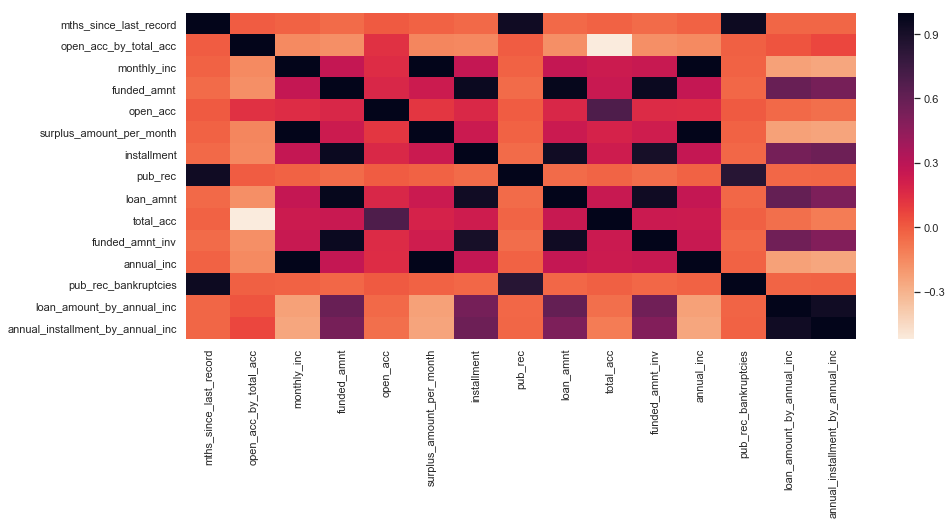

In [145]:
#subset dataframe on highly correlated columns
loan_high_corr_df = loan_df.loc[:,to_keep]
sns.heatmap(loan_high_corr_df.corr(),cmap =sns.cm.rocket_r)

In [146]:
loan_high_corr_df.corr().style.background_gradient()

,mths_since_last_record,open_acc_by_total_acc,monthly_inc,funded_amnt,open_acc,surplus_amount_per_month,installment,pub_rec,loan_amnt,total_acc,funded_amnt_inv,annual_inc,pub_rec_bankruptcies,loan_amount_by_annual_inc,annual_installment_by_annual_inc
mths_since_last_record,1,-0.00270591,-0.0176706,-0.0450441,0.00609323,-0.0167077,-0.0411206,0.935876,-0.0440968,-0.0162151,-0.0471814,-0.0176706,0.951221,-0.0304479,-0.0271111
open_acc_by_total_acc,-0.00270591,1,-0.147425,-0.164224,0.137056,-0.136009,-0.140211,0.00058437,-0.168757,-0.519836,-0.169103,-0.147425,-0.00965222,0.0238267,0.0665205
monthly_inc,-0.0176706,-0.147425,1,0.264798,0.156927,0.995452,0.267842,-0.017864,0.268999,0.234534,0.251981,1,-0.0159546,-0.234338,-0.250297
funded_amnt,-0.0450441,-0.164224,0.264798,1,0.175682,0.238248,0.958035,-0.0505762,0.98179,0.250551,0.956172,0.264798,-0.0361889,0.591587,0.538834
open_acc,0.00609323,0.137056,0.156927,0.175682,1,0.1207,0.172893,2.83629e-05,0.1772,0.68726,0.162738,0.156927,0.00561557,-0.0435626,-0.0604038
surplus_amount_per_month,-0.0167077,-0.136009,0.995452,0.238248,0.1207,1,0.241758,-0.0162396,0.242281,0.196574,0.225761,0.995452,-0.015335,-0.229331,-0.24316
installment,-0.0411206,-0.140211,0.267842,0.958035,0.172893,0.241758,1,-0.0457055,0.93226,0.22986,0.905464,0.267842,-0.0330383,0.544149,0.575109
pub_rec,0.935876,0.00058437,-0.017864,-0.0505762,2.83629e-05,-0.0162396,-0.0457055,1,-0.0499975,-0.0234942,-0.0514702,-0.017864,0.841571,-0.0366244,-0.0320441
loan_amnt,-0.0440968,-0.168757,0.268999,0.98179,0.1772,0.242281,0.93226,-0.0499975,1,0.256179,0.937922,0.268999,-0.0351408,0.603514,0.513583
total_acc,-0.0162151,-0.519836,0.234534,0.250551,0.68726,0.196574,0.22986,-0.0234942,0.256179,1,0.242715,0.234534,-0.0099978,-0.0600443,-0.10263


This gives us following list of highly correlated variables from our earlier identified most important variables.
* `annual_inc` - `surplus_amount_per_month`: consider any of these in important list of variables
* `loan_amount_by_annual_inc` - `annual_installment_by_annual_inc`: consider any of these in important list of variables
* `pub_rec_bankruptcies` - `pub_rec`: consider any of these in important list of variables


### Int_rate vs DTI

The correlation matrix is as below
          int_rate       dti
int_rate  1.000000  0.110913
dti       0.110913  1.000000
**********************************************************************************


C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


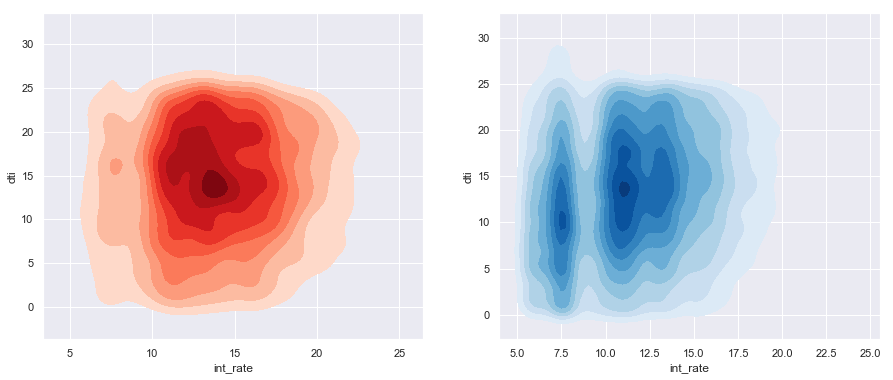

In [147]:
# Finding the correlation between the interest rate and the dti for loans which are paid and charged off

bi_analysis_num(loan_df[['int_rate' , 'dti' , 'loan_status']])

From above we observe that at same level of dti , if the loan has a higher interest rate ,there are high chances of default 

### DTI vs purpose

The summary table is as below
loan_status         Charged Off  Fully Paid   Total
purpose                                            
car                        0.41        3.47    3.89
credit_card                1.40       11.63   13.03
debt_consolidation         7.17       39.63   46.80
educational                0.15        0.70    0.84
home_improvement           0.90        6.55    7.45
house                      0.15        0.80    0.95
major_purchase             0.58        5.00    5.57
medical                    0.27        1.49    1.77
moving                     0.24        1.25    1.49
other                      1.64        8.38   10.02
renewable_energy           0.05        0.22    0.26
small_business             1.23        3.32    4.55
vacation                   0.14        0.83    0.97
wedding                    0.25        2.15    2.40
Total                     14.59       85.41  100.00
**********************************************************************************


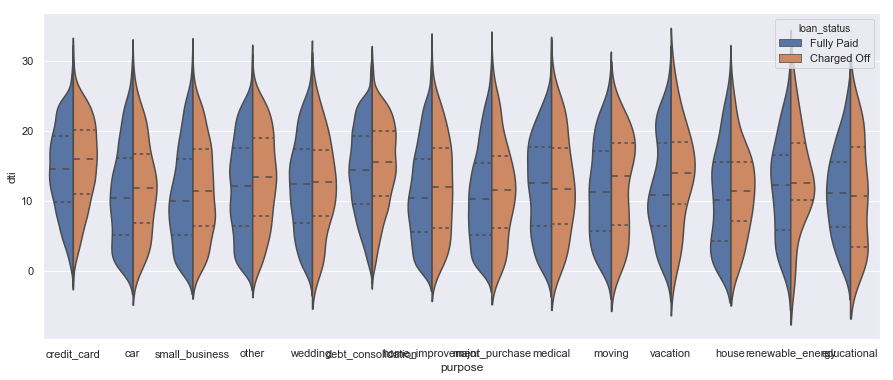

In [148]:
# Bivariate analysis of dti and purpose

bi_analysis_cat(loan_df[['dti' , 'purpose' , 'loan_status']])

The purpose for which loan is applied does indicate some chances for default. Some of the purposes have been identified as more risky ventures as compared to others . Analysing purpose alongwith dti, we see that loans taken for car , small business , home improvement are risky even at lower dti

### Dti vs home ownership 

The summary table is as below
loan_status     Charged Off  Fully Paid   Total
home_ownership                                 
MORTGAGE               6.03       38.09   44.12
NONE                   0.00        0.01    0.01
OTHER                  0.05        0.21    0.25
OWN                    1.15        6.56    7.71
RENT                   7.36       40.54   47.90
Total                 14.59       85.41  100.00
**********************************************************************************


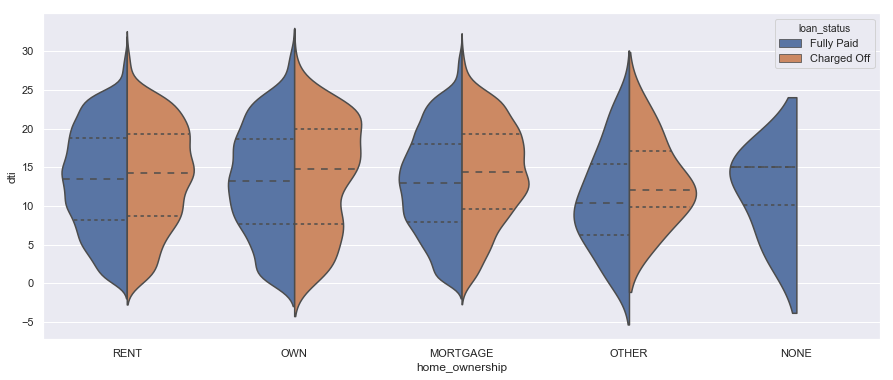

In [149]:
bi_analysis_cat(loan_df[['dti' , 'home_ownership' , 'loan_status']])

The type of home ownership do not show any significant difference on the final loan status. 

### dt vs inquiries in the last 6 months to understanding the availablity background information 

                     dti  inq_last_6mths
dti             1.000000        0.002178
inq_last_6mths  0.002178        1.000000
The summary table is as below
loan_status     Charged Off  Fully Paid   Total
inq_last_6mths                                 
0                      5.91       42.59   48.50
1                      4.35       23.29   27.63
2                      2.44       12.21   14.66
3                      1.60        6.13    7.73
4                      0.13        0.69    0.82
5                      0.07        0.30    0.37
6                      0.04        0.12    0.16
7                      0.03        0.06    0.09
8                      0.01        0.03    0.04
Total                 14.59       85.41  100.00
**********************************************************************************


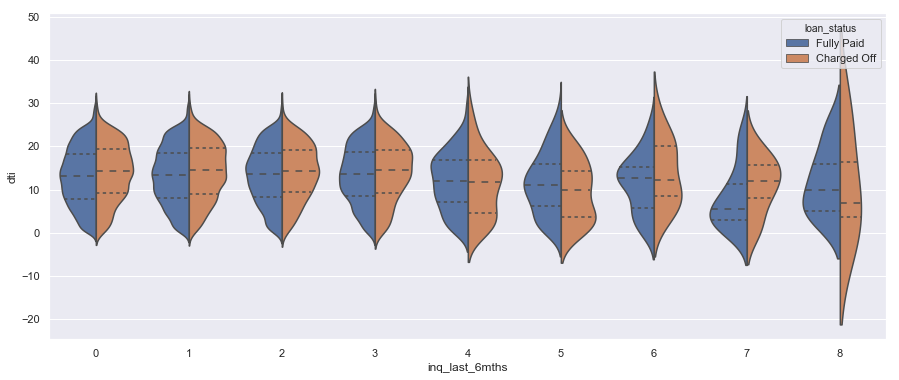

In [150]:
# Understanding the relation between dti and enquiries in last 6 months 

print(loan_df[['dti' , 'inq_last_6mths']].corr())

bi_analysis_cat(loan_df[['dti' , 'inq_last_6mths' , 'loan_status']])

As number of inquiries for loan increase the possibility to default at lower dti increases . Thus number of inquiries is a good leading indicator for the tendency to borrow and default even with lower dtis. However since the correlation between inquiries and dti is low , it does not indicate a 'credit seeking tendency'

### Funded amount invested vs past bankruptcies 

                 funded_amnt_inv  inq_last_6mths
funded_amnt_inv           1.0000         -0.0028
inq_last_6mths           -0.0028          1.0000
**************************************************************************************************
The summary table is as below
loan_status           Charged Off  Fully Paid   Total
pub_rec_bankruptcies                                 
0.0                         13.63       82.11   95.74
1.0                          0.95        3.29    4.24
2.0                          0.01        0.01    0.01
Total                       14.59       85.41  100.00
**********************************************************************************


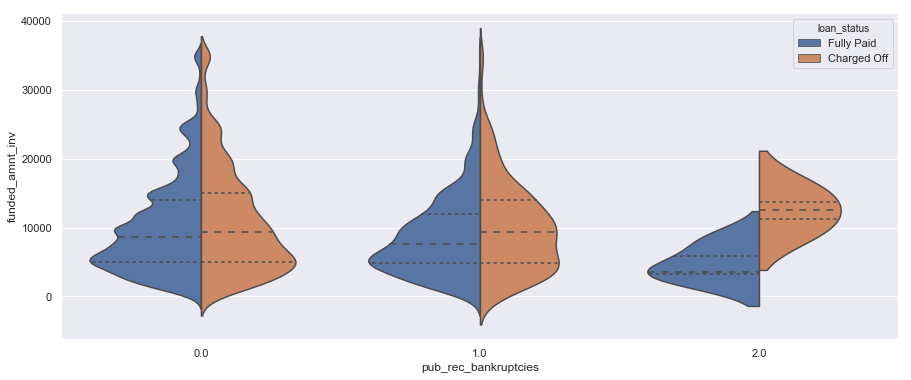

In [151]:
print(loan_df[['funded_amnt_inv' , 'inq_last_6mths']].corr())

print('**************************************************************************************************')

bi_analysis_cat(loan_df[['funded_amnt_inv' , 'pub_rec_bankruptcies' , 'loan_status']])

The correlation between funded amount invested and number of bankrupties is very low. Thus the members who invest in loan do not have enough information about the past bankrupties. 

Past bankruptcy is an established indicator of default . Transfer of the infromation to the investors can reduce the investment in risky loans 

### Funded amount vs dti

The correlation matrix is as below
                 funded_amnt_inv       dti
funded_amnt_inv         1.000000  0.070663
dti                     0.070663  1.000000
**********************************************************************************


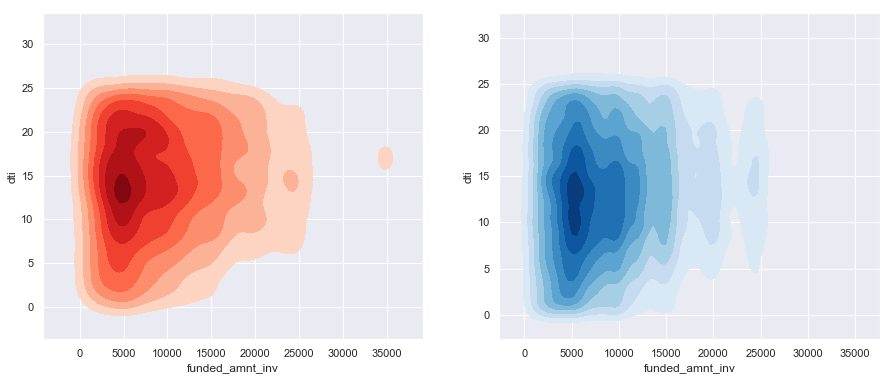

In [152]:
bi_analysis_num(loan_df[['funded_amnt_inv' , 'dti' , 'loan_status']])

It seems that Information of the dti not available to the investors since higher dti should ideally reduce the investment in the loan and thus serve as a leadfing indicator 

## Conclusions

Our analysis concludes that following are the most important variables that Lending Club should be interested in while making decision regarding loan approval.
* Customer Variable
    1. `annual_inc` / `surplus_amount_per_month`
    2. `pub_rec` / `pub_rec_bankruptcies`
* Loan Variable
    3. `int_rate`
    4. `term`
    5. `revol_utl`
    6. `inq_last_6mths`
* Derived variable
    7. `annual_installment_by_annual_inc` / `loan_amount_by_annual_inc`